## NLP10. Transformer로 번역기 만들기

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import re
import random
import collections
import logging
import pathlib
import string
import sys
import time
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from keras.preprocessing.text import Tokenizer
import warnings
warnings.filterwarnings("ignore")

print(tf.__version__)
print(np.__version__)
print(matplotlib.__version__)

2.6.0
1.21.4
3.4.3


In [2]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data' #파일 경로 지정하여 병렬적으로 데이터 불러오기
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as g: eng = g.read().splitlines()
    set_raw = set(zip(kor,eng))
    
    return set_raw

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [3]:
def preprocess_sentence(sentence):                 # 데이터 정제
    sentence = sentence.lower().strip()
    
    sentence = re.sub(r"([?.!,])",r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)

    sentence = sentence.strip()
        
    return sentence 

In [4]:
pip install sentencepiece

Note: you may need to restart the kernel to use updated packages.


In [5]:
import sentencepiece as spm   #토큰화 함수

def generate_tokenizer(lang, pad_id=0, bos_id=1, eos_id=2, unk_id=3):

    if(lang=="ko") : 
        spm.SentencePieceTrainer.Train('--input={} --model_prefix=m \
        --vocab_size={} --pad_id=0 \
        --unk_id=3'.format(kor_path, SRC_VOCAB_SIZE))
        sp_k = spm.SentencePieceProcessor()
        sp_k.Load('m.model')
        return sp_k 
        
    if(lang=="en") : 
        spm.SentencePieceTrainer.Train('--input={} --model_prefix=n \
        --vocab_size={} --pad_id=0 --bos_id=1 \
        --eos_id=2 --unk_id=3'.format(eng_path, TGT_VOCAB_SIZE))
        sp_e = spm.SentencePieceProcessor()
        sp_e.Load('n.model')
        return sp_e

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 30000 

ko_tokenizer = generate_tokenizer("ko")
en_tokenizer = generate_tokenizer("en")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/transformer/data/korean-english-park.train.ko --model_prefix=m         --vocab_size=30000 --pad_id=0         --unk_id=3
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/transformer/data/korean-english-park.train.ko
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 30000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 

### 훈련 데이터 최종 결정

In [6]:
from tqdm import tqdm    # Process 과정을 보기 위해
sp = spm.SentencePieceProcessor()

kor_corpus = []; src_corpus = []
eng_corpus = []; tgt_corpus = []

for pair in cleaned_corpus :
    k, e = pair
    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))
    
assert len(kor_corpus) == len(eng_corpus)


# 토큰의 길이가 50 이하인 문장만 남깁니다. 

sp = spm.SentencePieceProcessor()
sp.Load('m.model'); sp.Load('n.model')

for idx in tqdm(range(len(kor_corpus))):
    if(len(ko_tokenizer.EncodeAsIds(kor_corpus[idx]))<=50) :
        tgt_corpus.append(en_tokenizer.EncodeAsIds(eng_corpus[idx])) 
        src_corpus.append(ko_tokenizer.EncodeAsIds(kor_corpus[idx]))
    else : continue

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

100%|██████████| 78968/78968 [00:05<00:00, 13339.42it/s]


### 데이터가 올바르게 찍히는지 검사

In [7]:
print(type(enc_train))
print(type(dec_train))
print(kor_corpus[1])
print(eng_corpus[1])
print(enc_train.shape)
print(dec_train.shape)
print(enc_train)
print(dec_train)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
당신은 나를 코너로 몰아넣었고 나는 한가지 방법 밖에 없었어 .
you forced me into a corner and gave me only one option .
(77312, 50)
(77312, 114)
[[16411     9 26483 ...     0     0     0]
 [ 1391    12   298 ...     0     0     0]
 [   38   140  1931 ...     0     0     0]
 ...
 [ 9535    12  2557 ...     0     0     0]
 [ 7459   621    24 ...     0     0     0]
 [25148  1656     6 ...     0     0     0]]
[[ 122    7 1942 ...    0    0    0]
 [ 113   15 2066 ...    0    0    0]
 [  36   72   16 ...    0    0    0]
 ...
 [3186 2340   87 ...    0    0    0]
 [3478  723   15 ...    0    0    0]
 [   4 2411  326 ...    0    0    0]]


In [8]:
print(ko_tokenizer.DecodeIds(src_corpus[8]))
print(en_tokenizer.DecodeIds(tgt_corpus[8]))

년 월 부시 행정부의 신속협상권 tpa 이 만료되는 사실을 언급하면서 년 말까지 한미 fta 협상을 마무리해야 한다고 밝힌 것이다 .
mentioning that the right of u . s . president george w . bush to negotiate trade and commerce agreements will expire in june she said the administration is obliged to finish the korea u . s .


### 트랜스포머의 여러 요소(클래스 or 함수) 정의

In [9]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

print("슝=3")

슝=3


In [10]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
            
        self.depth = d_model // self.n_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.n_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    				        
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights
print("슝=3")

슝=3


In [11]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

print("슝=3")

슝=3


In [12]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

print("슝=3")

슝=3


In [13]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, n_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, n_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [14]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

print("슝=3")

슝=3


In [15]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

print("슝=3")

슝=3


In [16]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

print("슝=3")

슝=3


In [17]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

print("슝=3")

슝=3


### 훈련 및 결과산출 함수 정의

In [18]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)


In [19]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [20]:
@tf.function
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]

    with tf.GradientTape() as tape:
        
        enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)
        
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:,:-1])

        variables = model.encoder.trainable_variables + model.decoder.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

### 여러 상수들 정의와 트랜스포머 객체 정의

In [21]:
from tensorflow import keras

d_model = 512; n_layers = 2; n_heads = 8; d_ff = 2048
dropout = 0.1; pos_len = 512
seq_len = 50; src_vocab_size = SRC_VOCAB_SIZE = 30000
tgt_vocab_size = TGT_VOCAB_SIZE = 30000

Tran = Transformer(n_layers, d_model, n_heads, d_ff, src_vocab_size, tgt_vocab_size, pos_len, dropout=0.2, shared=True)
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

### 번역과 어텐션 시각화 함수 정의

In [22]:
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [23]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [24]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [25]:
sp_k = spm.SentencePieceProcessor(); sp_k.Load('m.model')
sp_e = spm.SentencePieceProcessor(); sp_e.Load('n.model')

True

In [26]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("슝=3")

슝=3


### 훈련 및 관찰

Epoch 20: 100%|██████████| 1208/1208 [07:24<00:00,  2.71it/s, Loss 1.9464]


Input: 오바마는 대통령이다.
Predicted translation: he s going to take over from obama . . . . . . . . that he has a chance to see his own . . . . . . . . . . . he said he . he s going to take over his life . that he . that he .Britain cat . . . . . . . . . . . . . . .
Encoder Layer 1


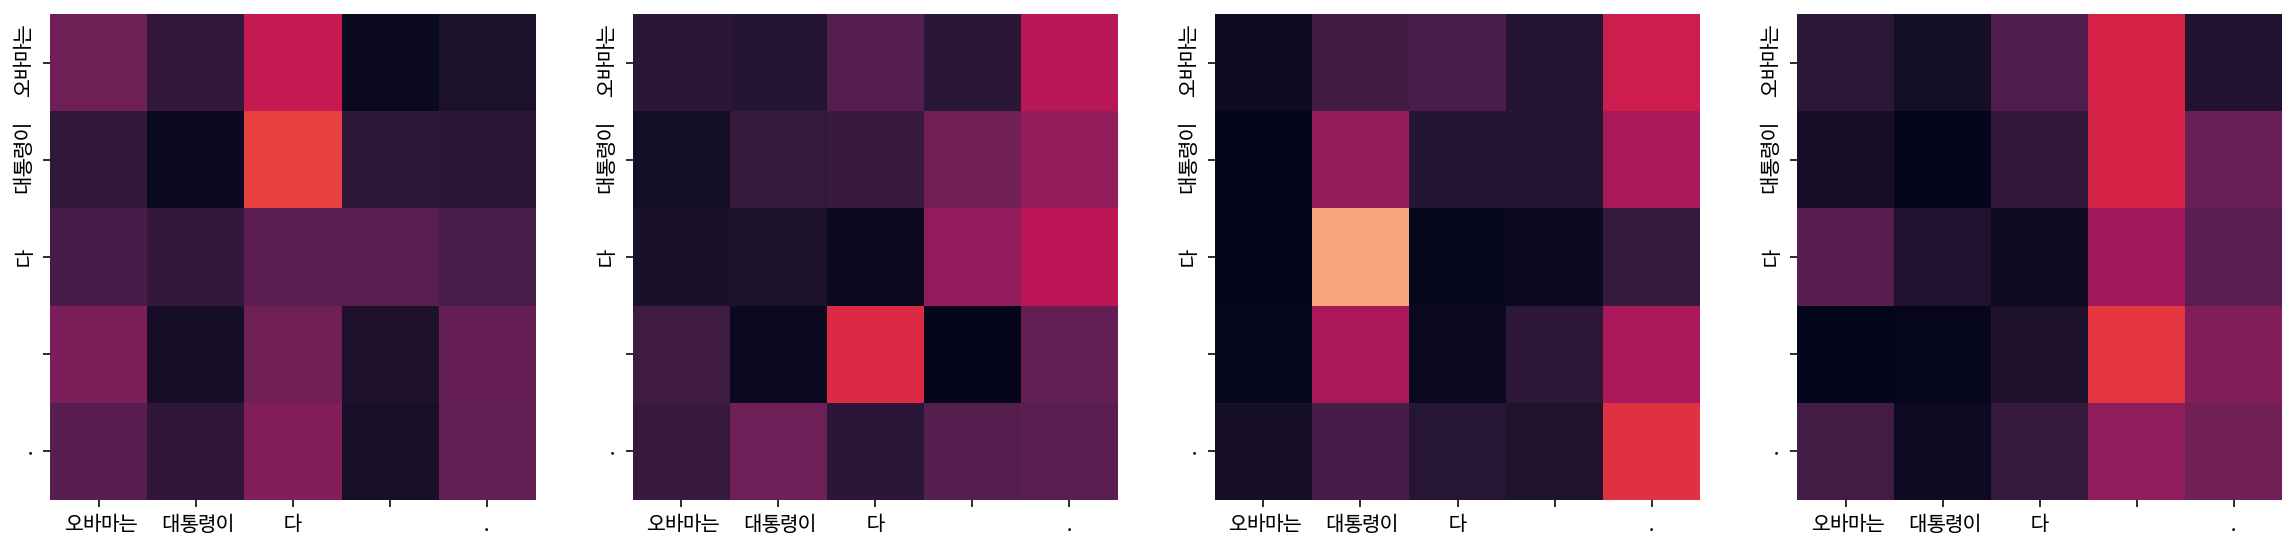

Encoder Layer 2


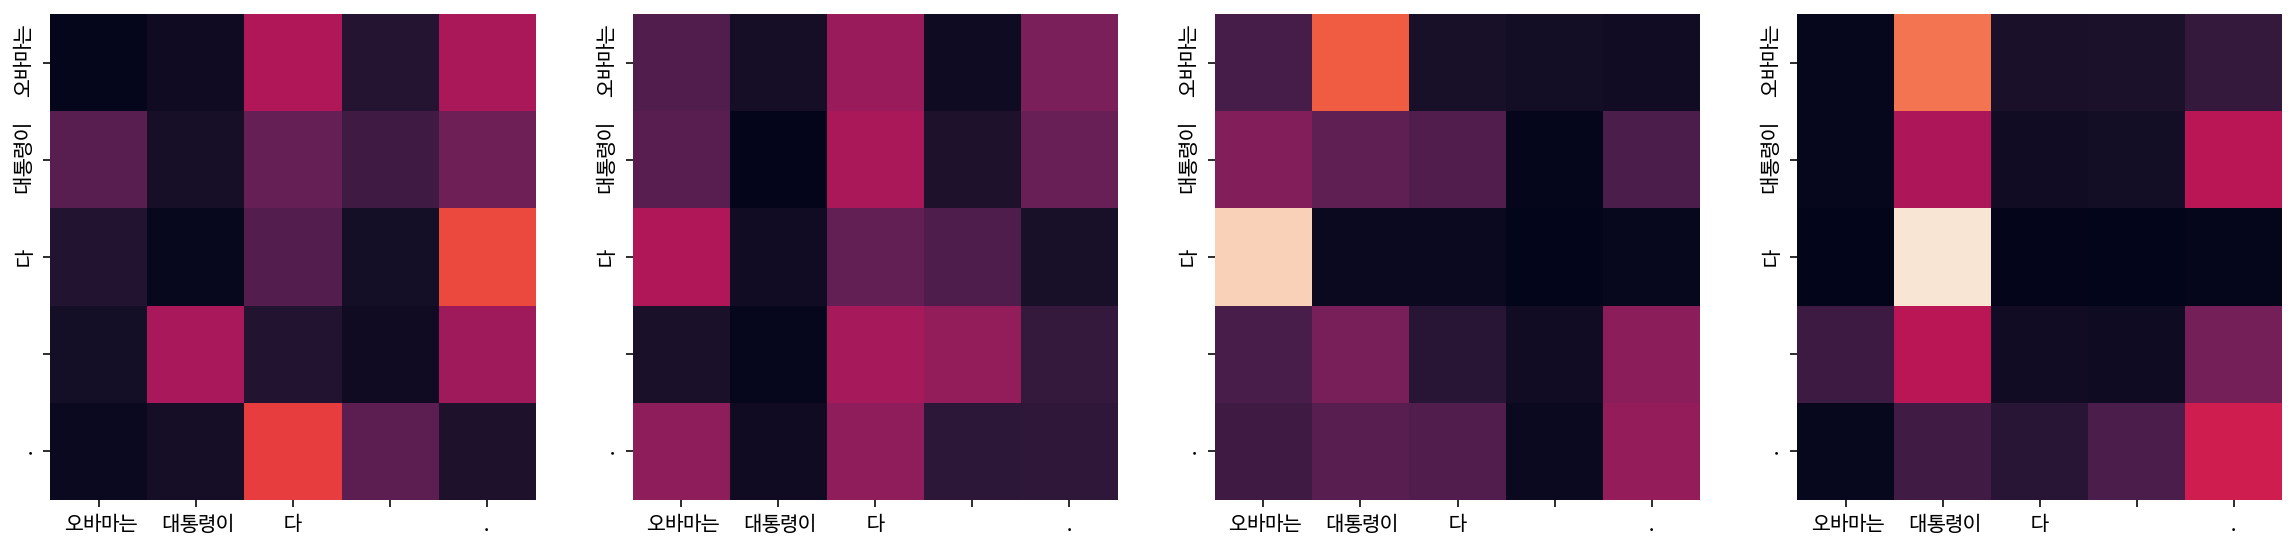

Decoder Self Layer 1


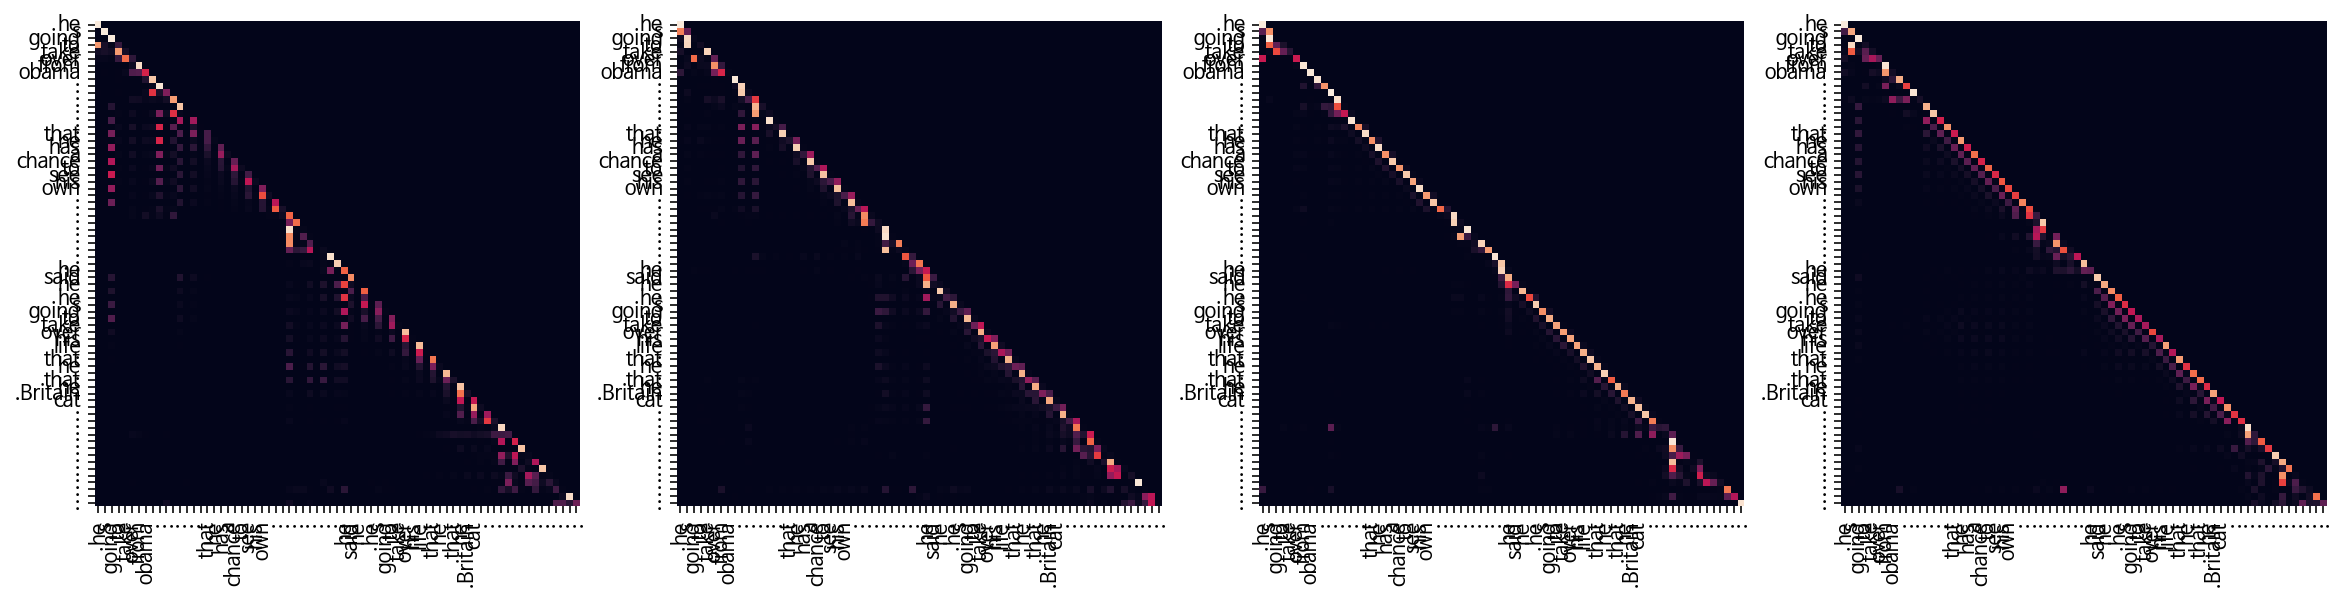

Decoder Src Layer 1


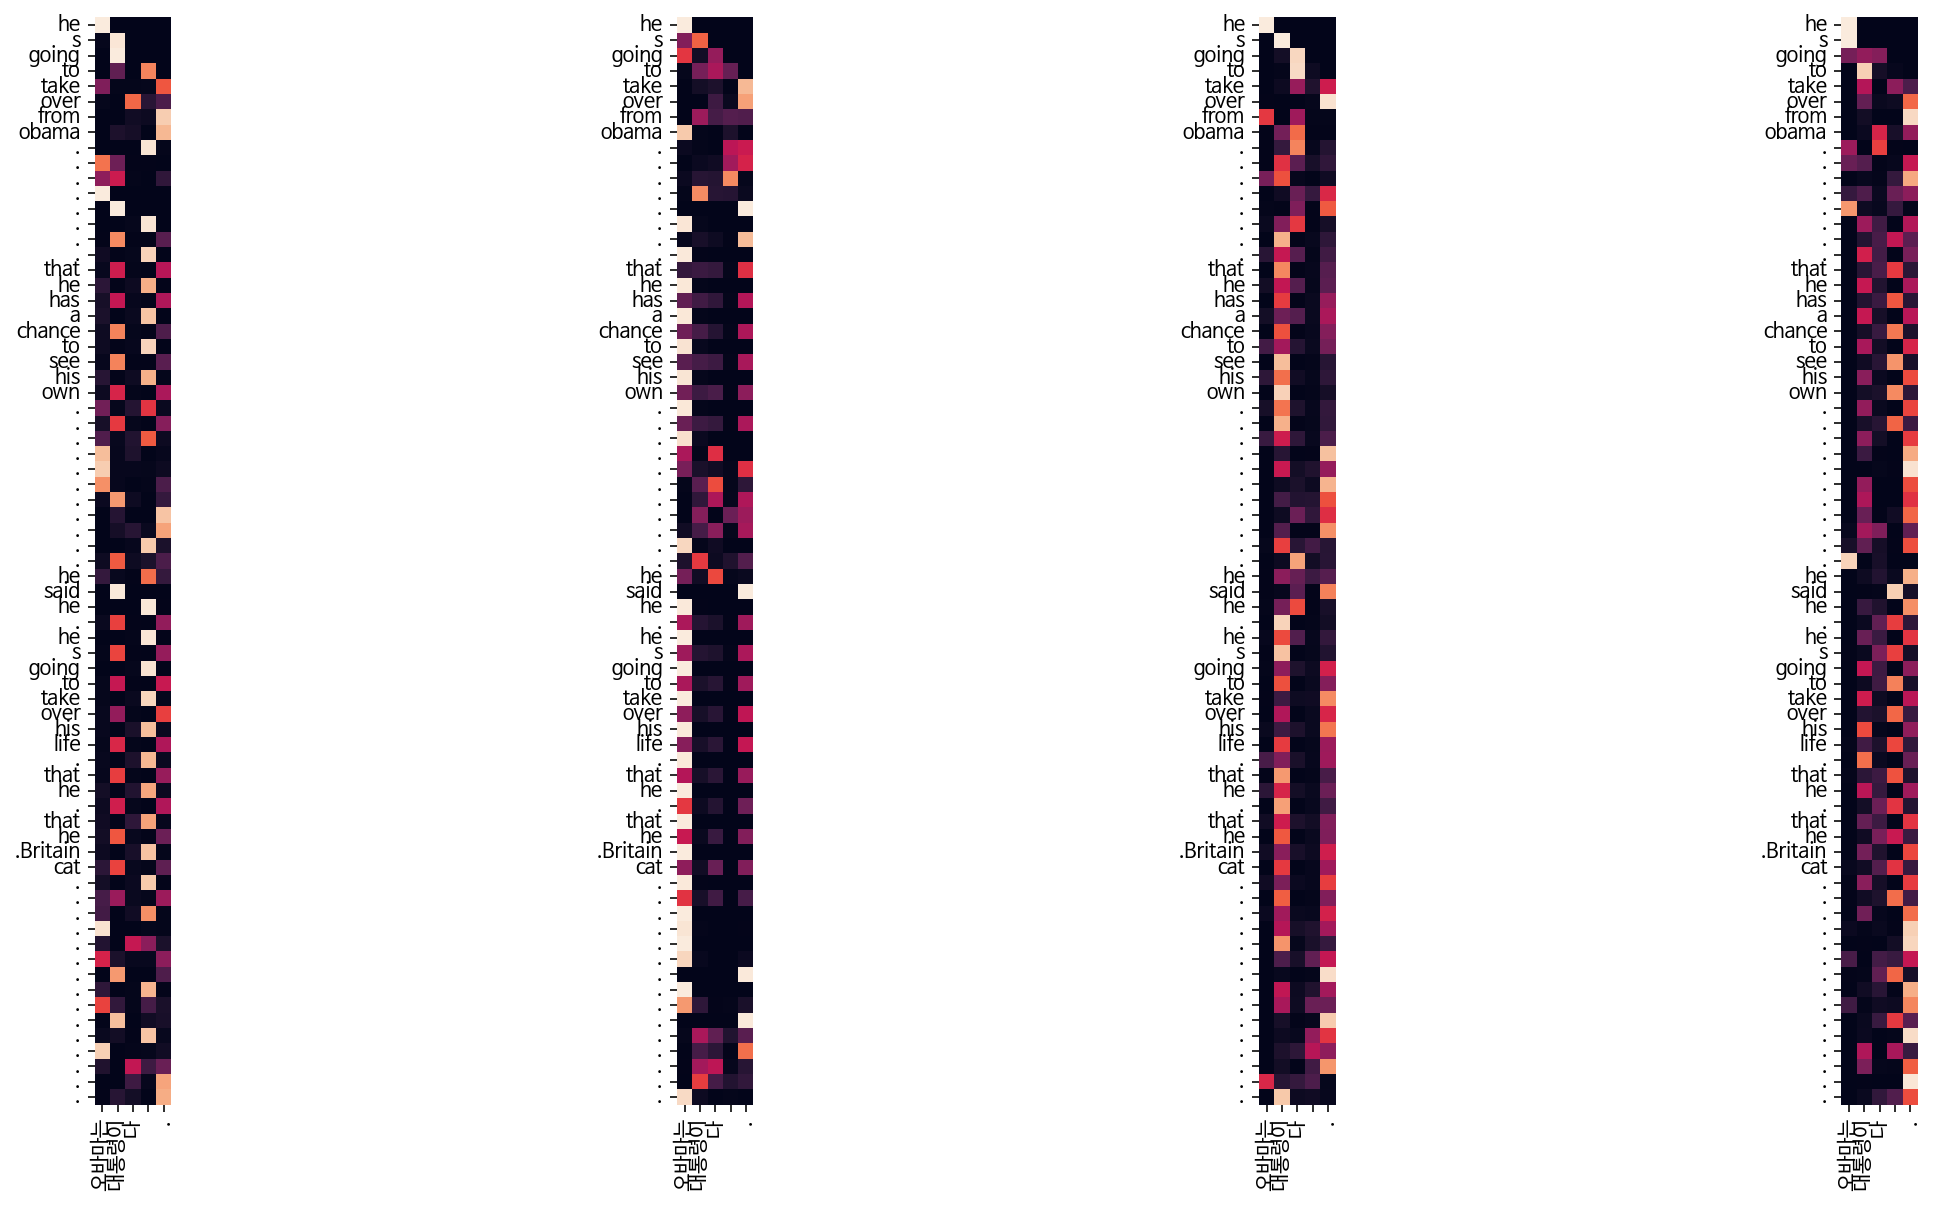

Decoder Self Layer 2


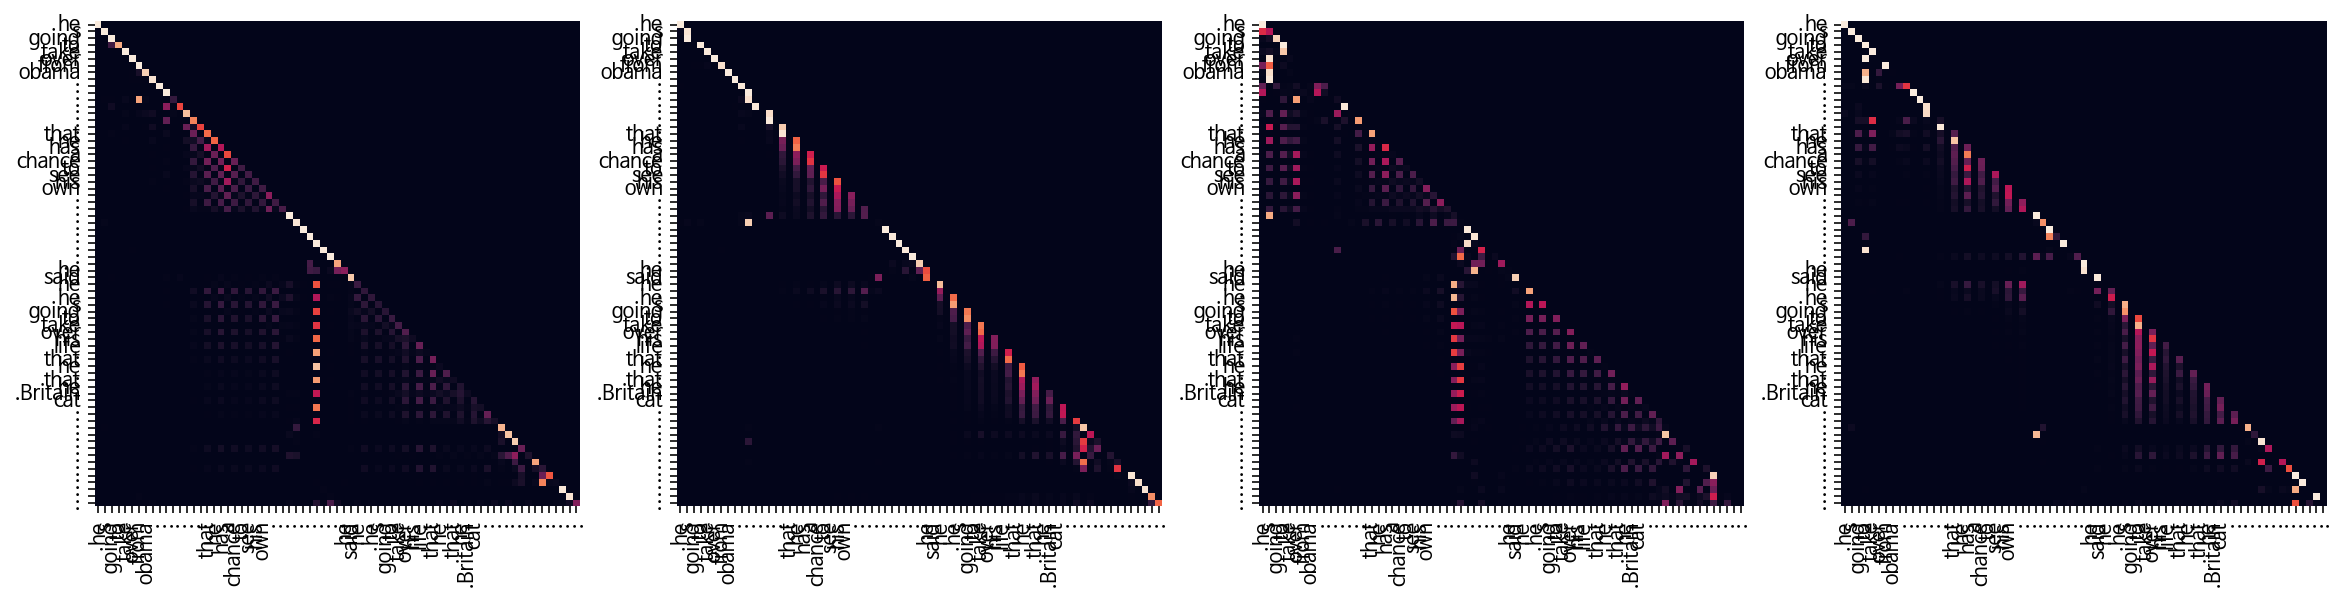

Decoder Src Layer 2


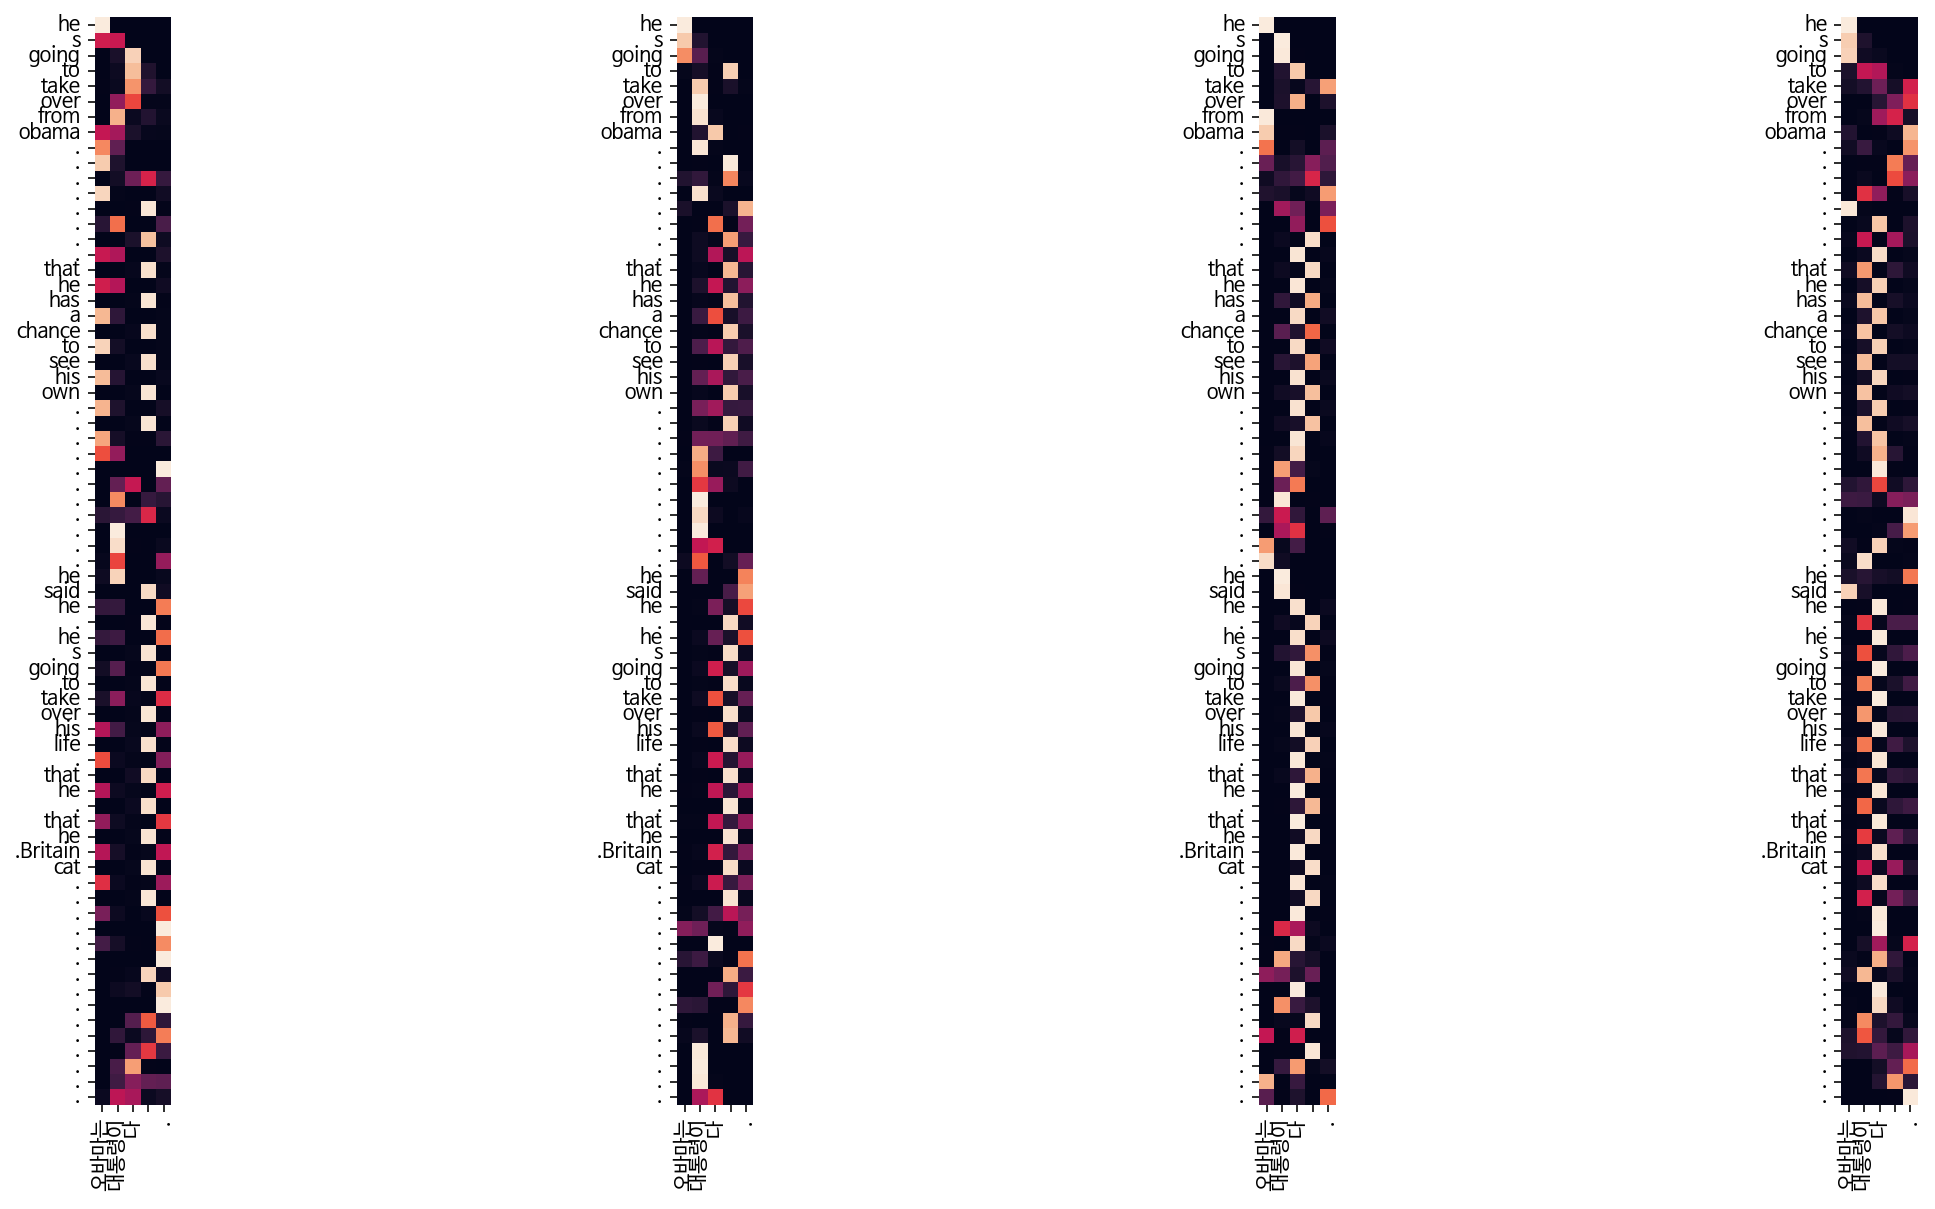

Input: 시민들은 도시 속에 산다.
Predicted translation: discoveriesed as well . million is . . . . . . . . . . . . . . . . . . . deep people . in the city city .q st . state friday . c at the Saf . c . about . jack Travelers . . million apiece . . . . . . . . san . . . . . 
Encoder Layer 1


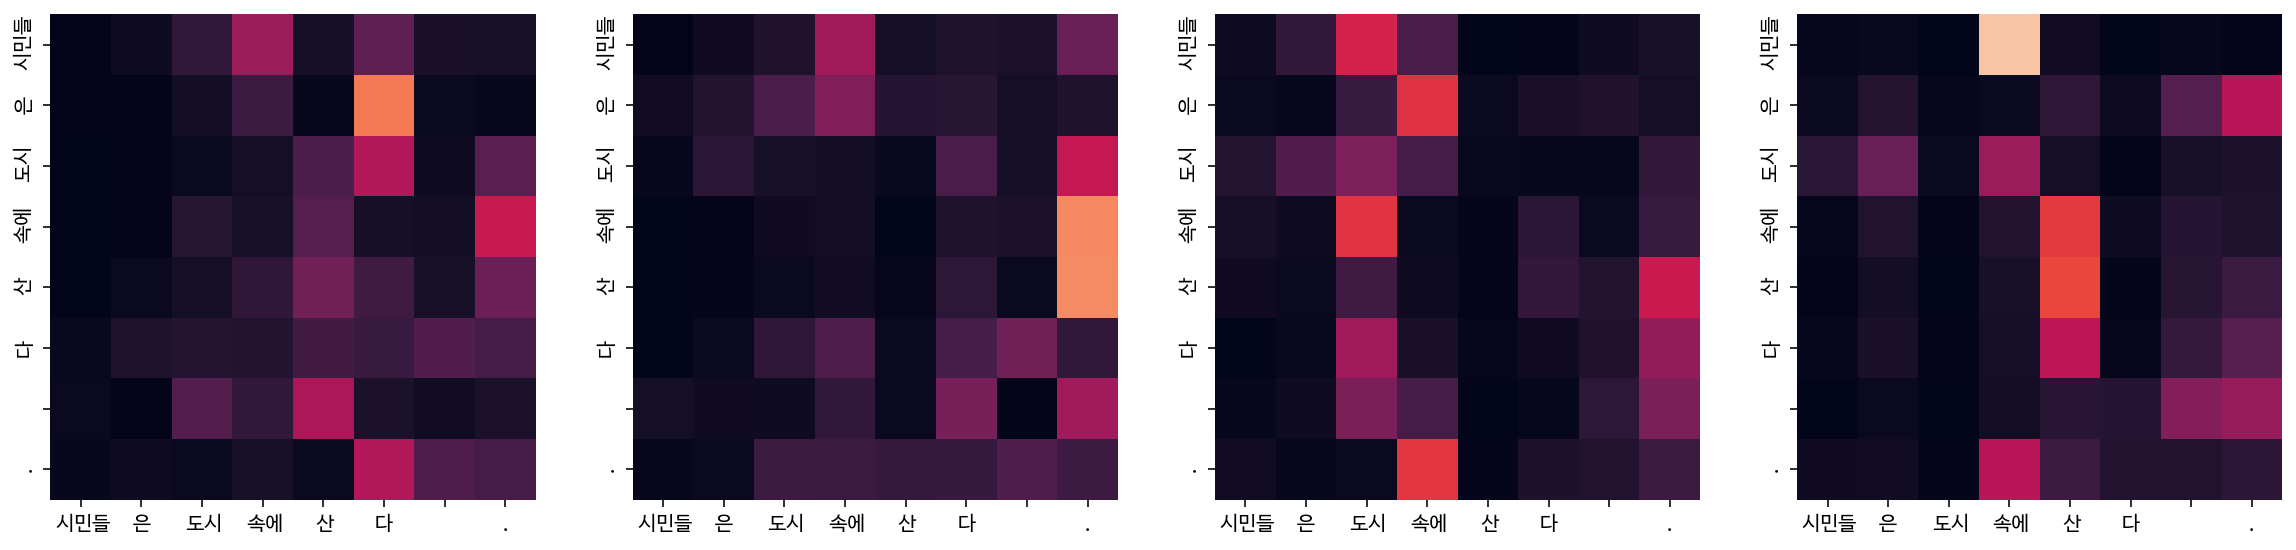

Encoder Layer 2


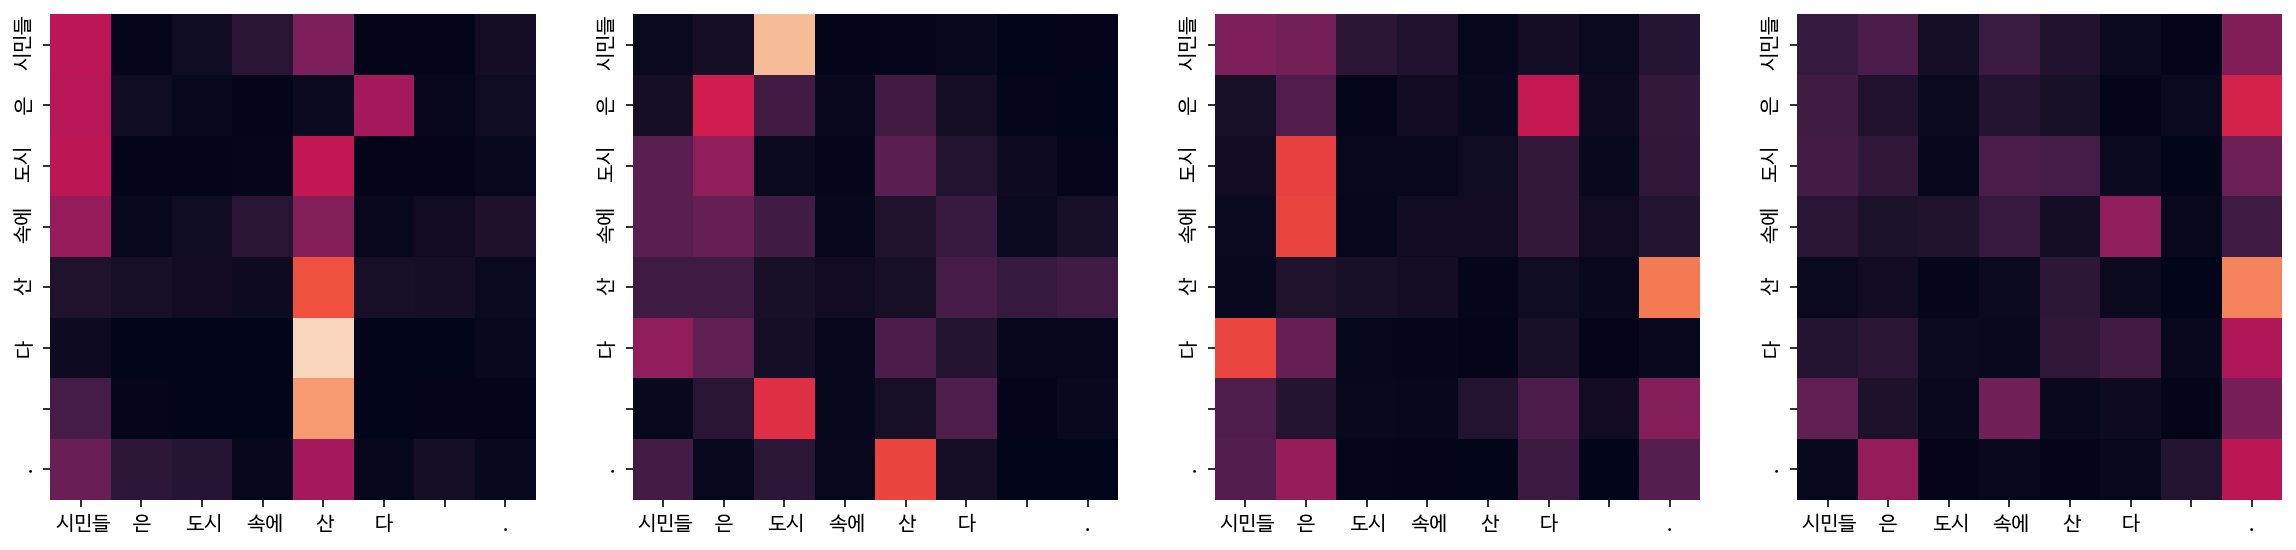

Decoder Self Layer 1


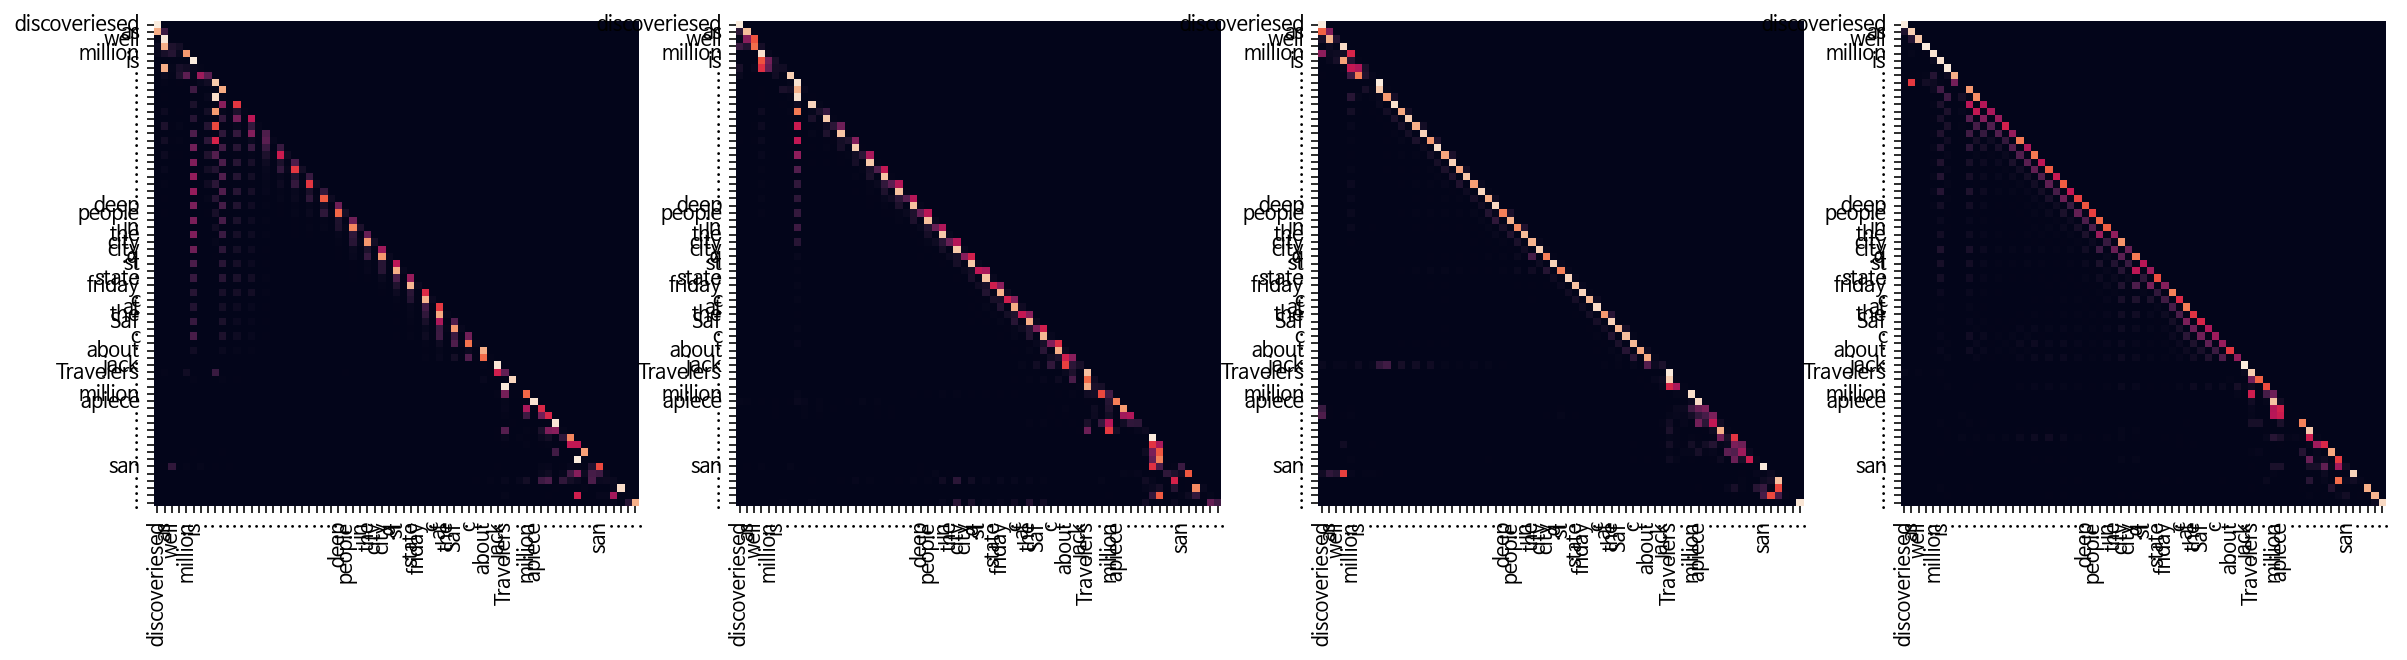

Decoder Src Layer 1


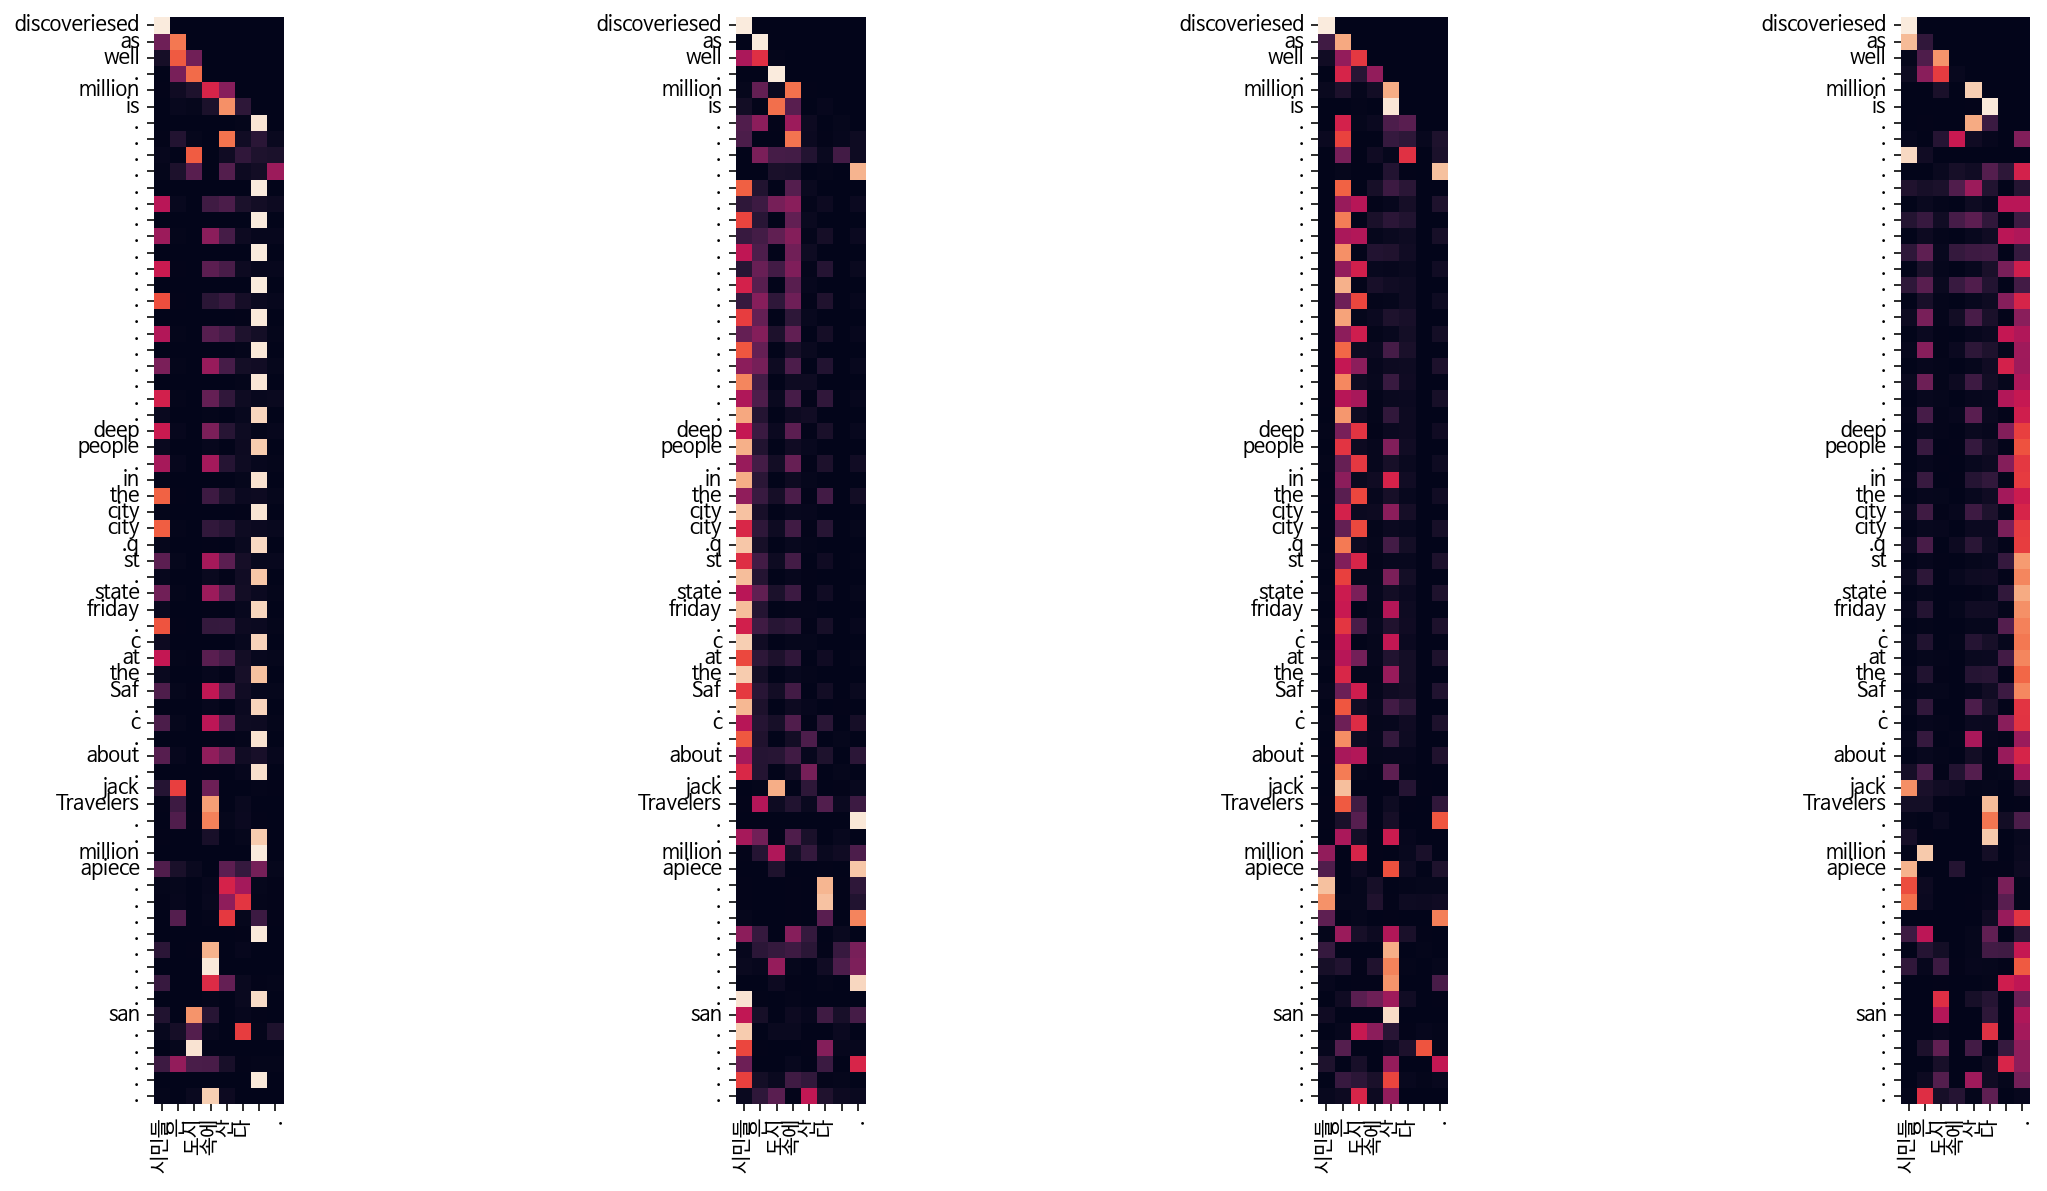

Decoder Self Layer 2


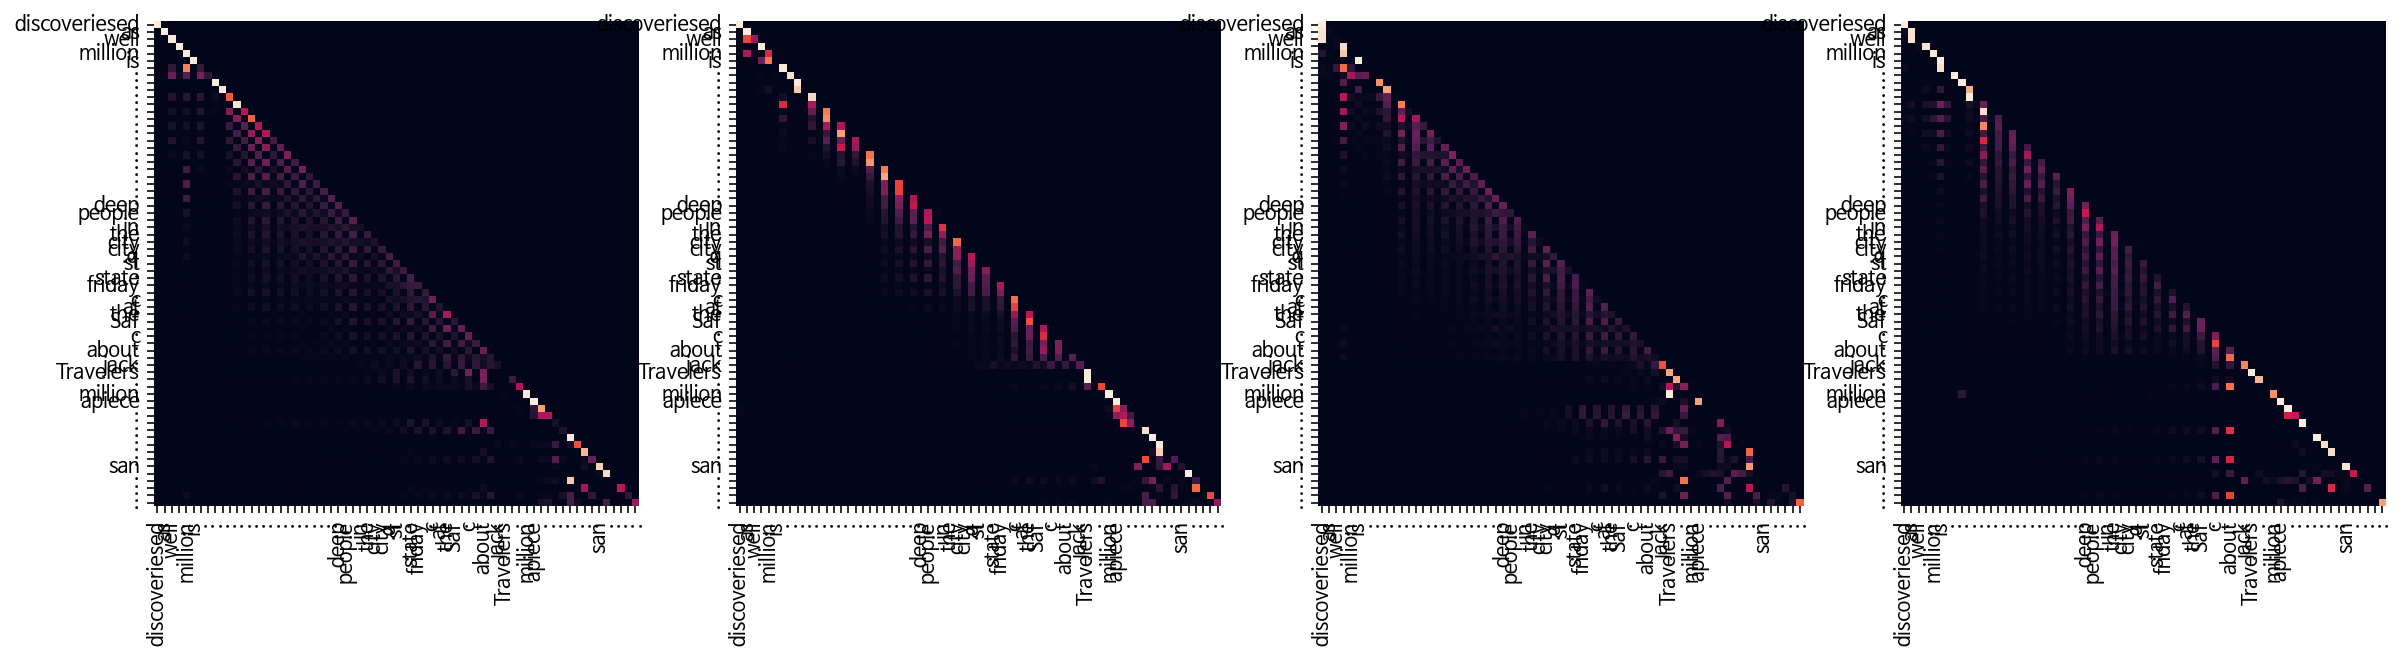

Decoder Src Layer 2


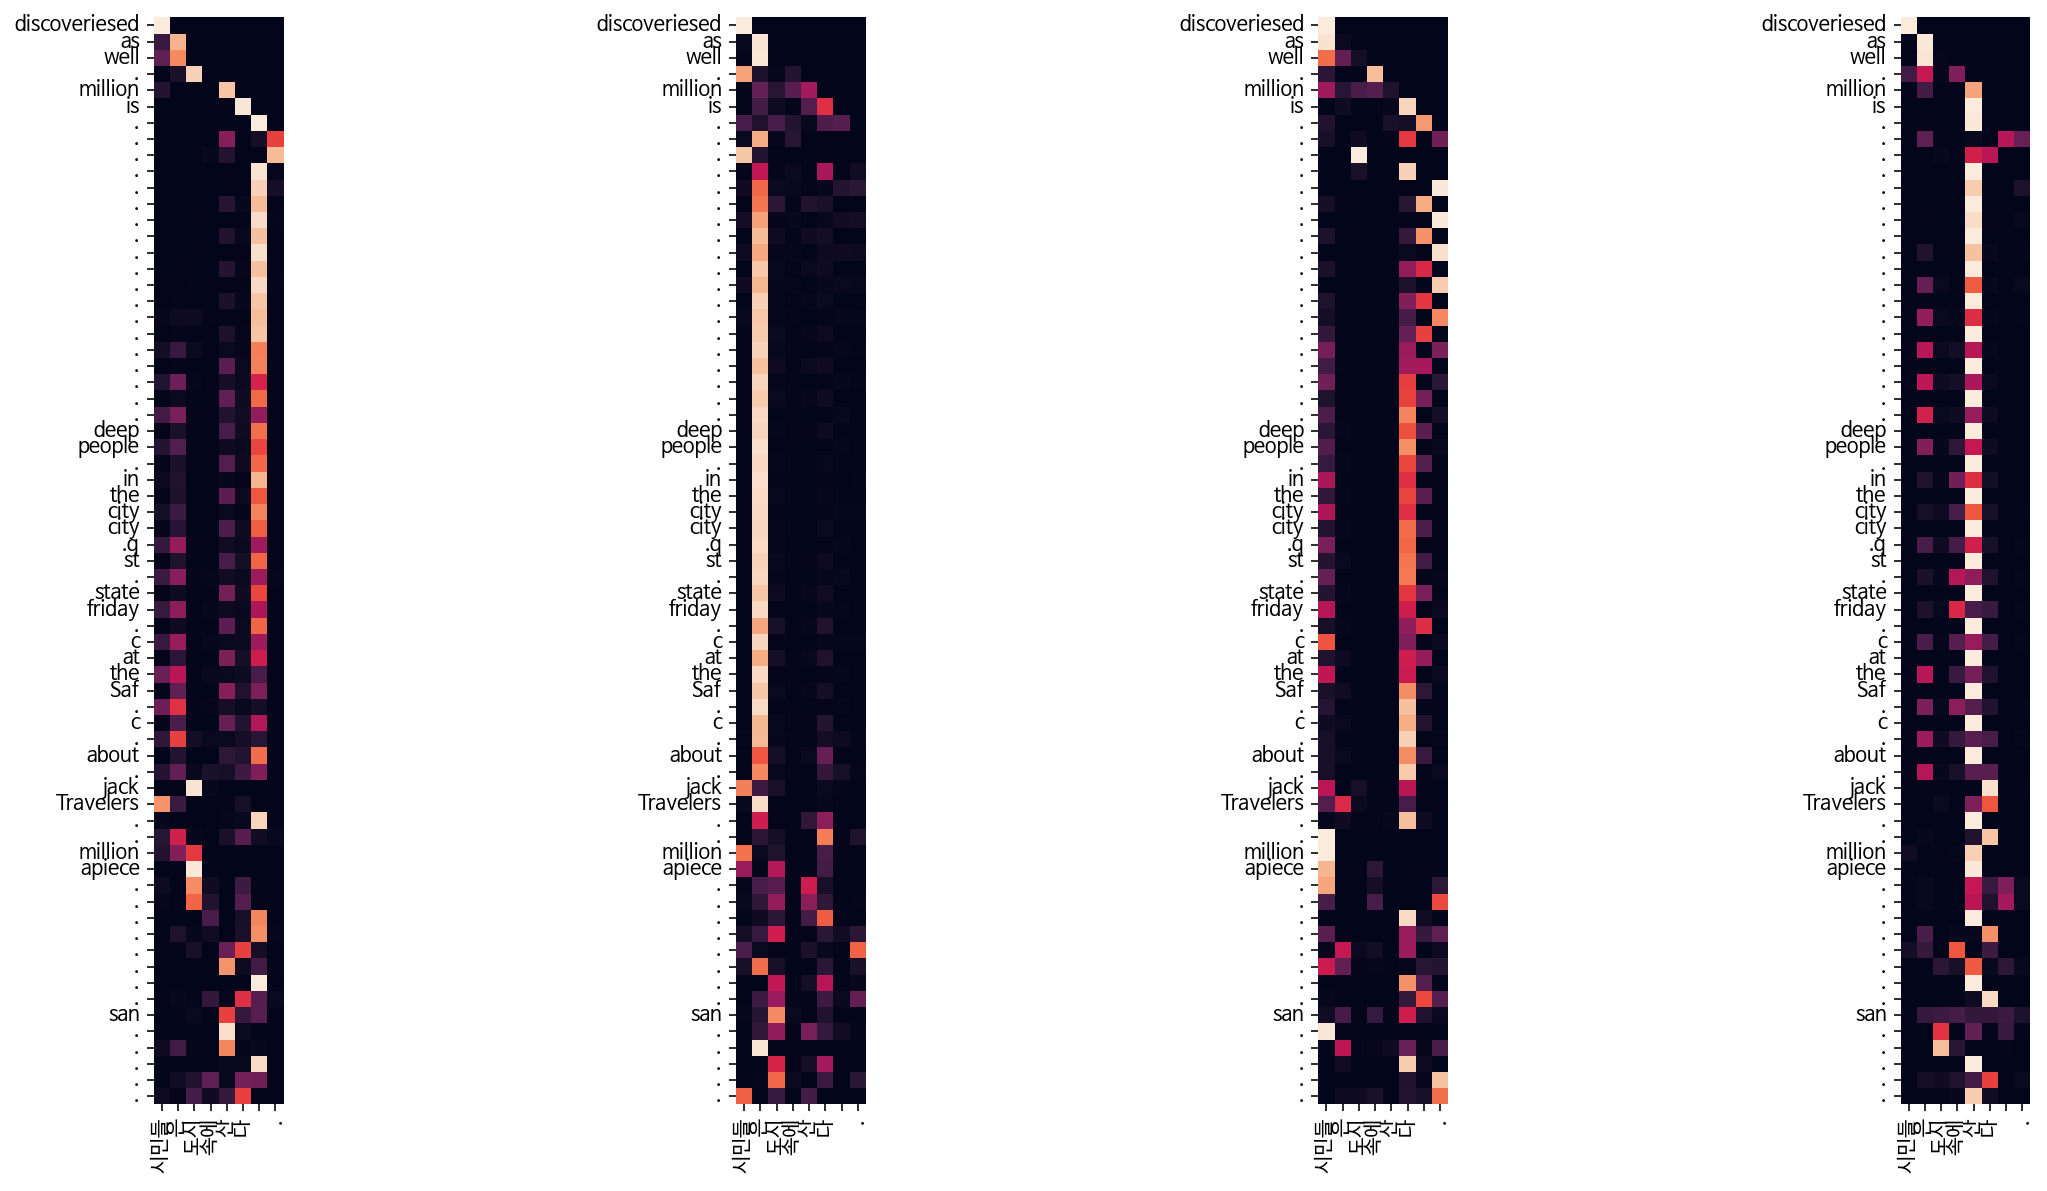

Input: 커피는 필요 없다.
Predicted translation: . com adviser . . com acquisition Gianlu,516 about . s climate change . comSigmund ⁇  . . . . . . . . . . . . . . . . . . cleric . . . . . . . . . . . . . . . . . . . . . . . . .
Encoder Layer 1


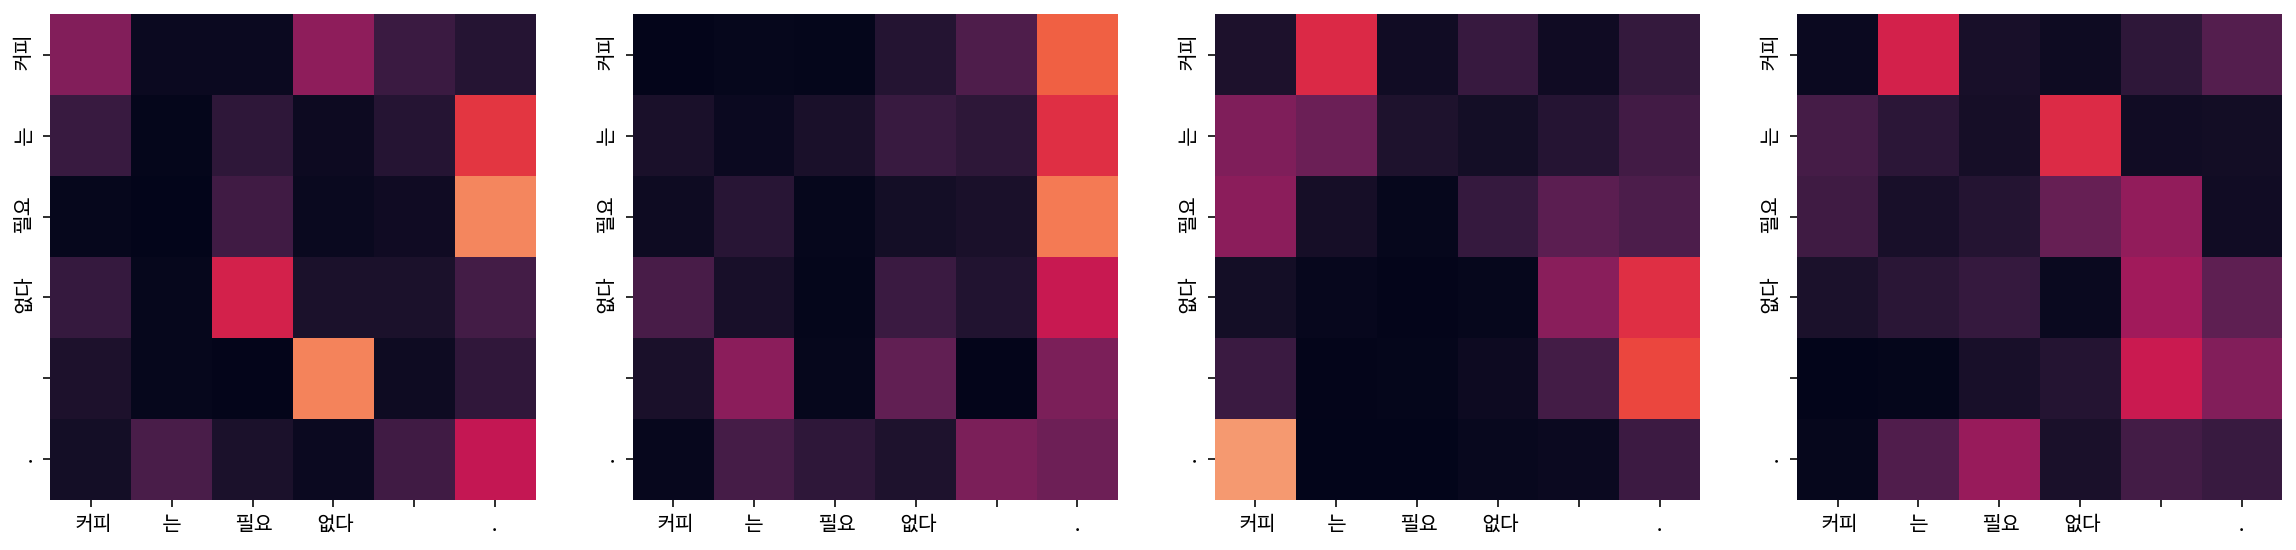

Encoder Layer 2


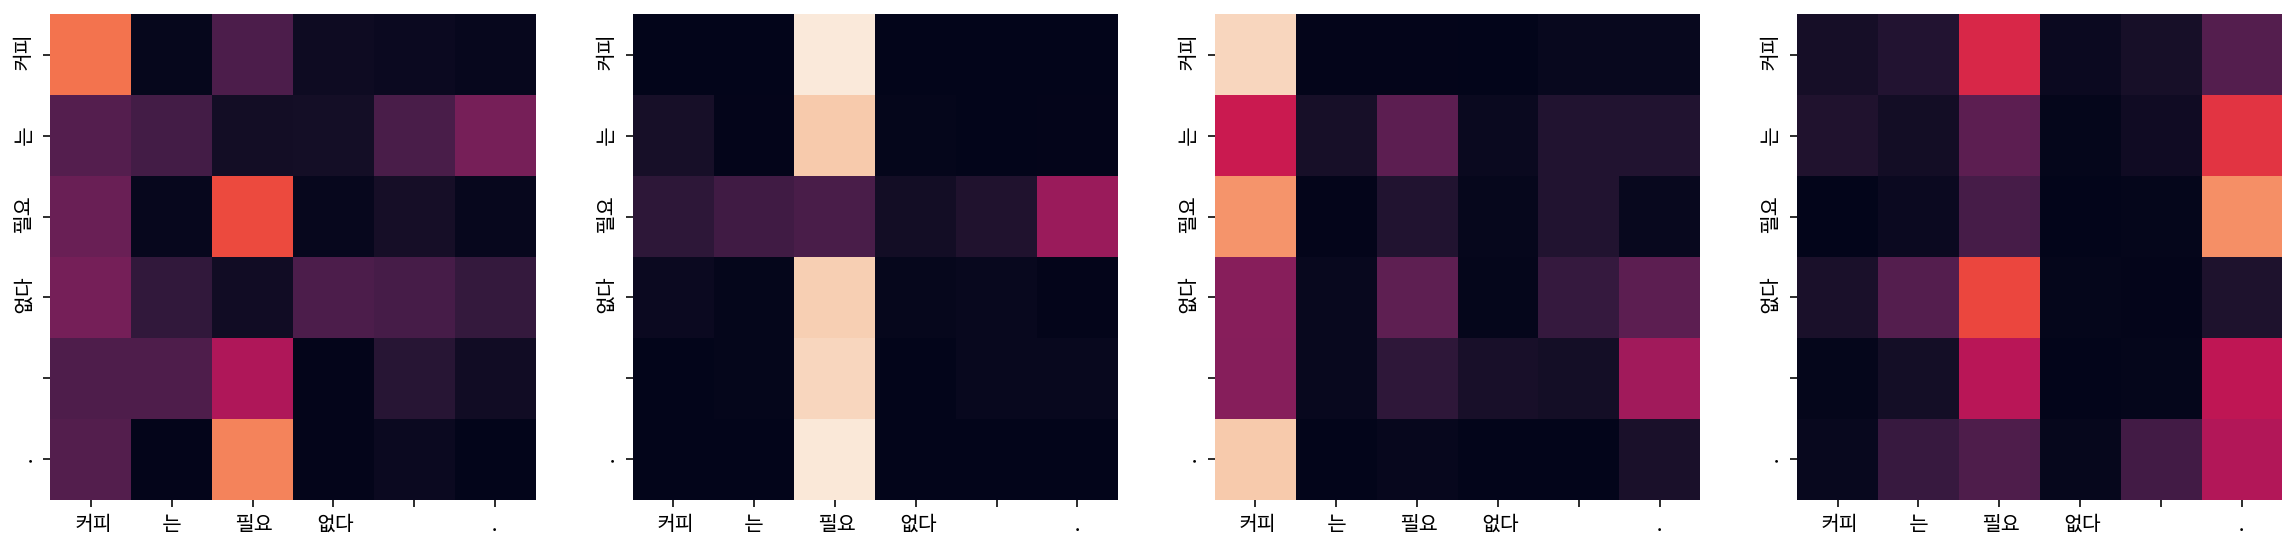

Decoder Self Layer 1


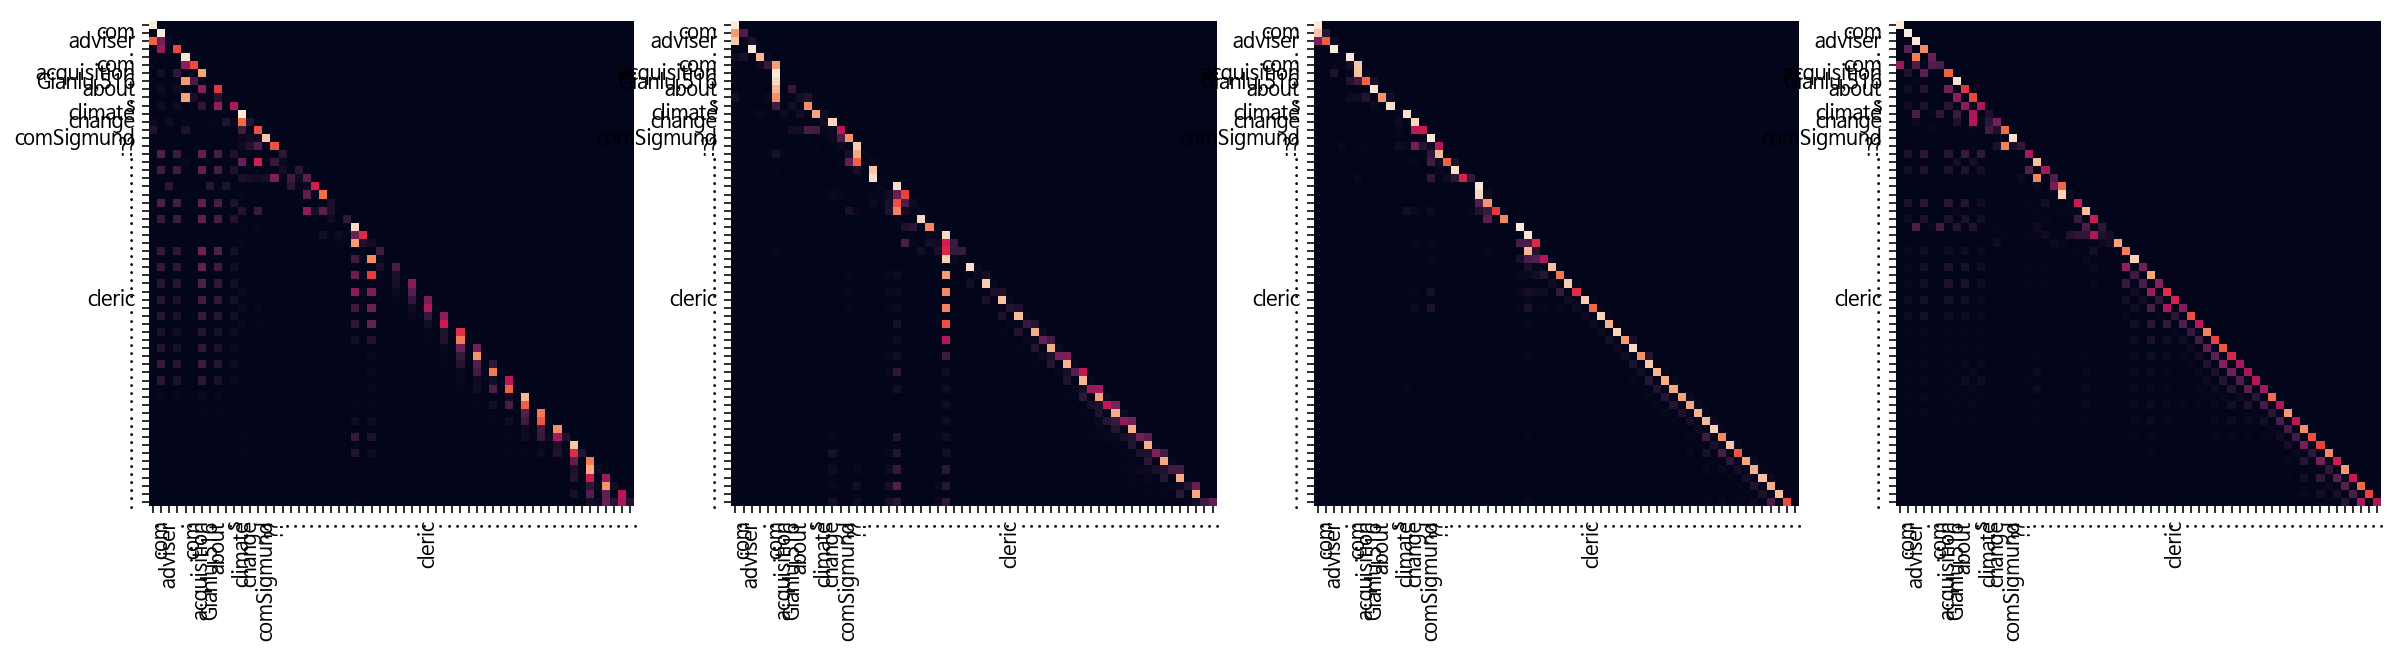

Decoder Src Layer 1


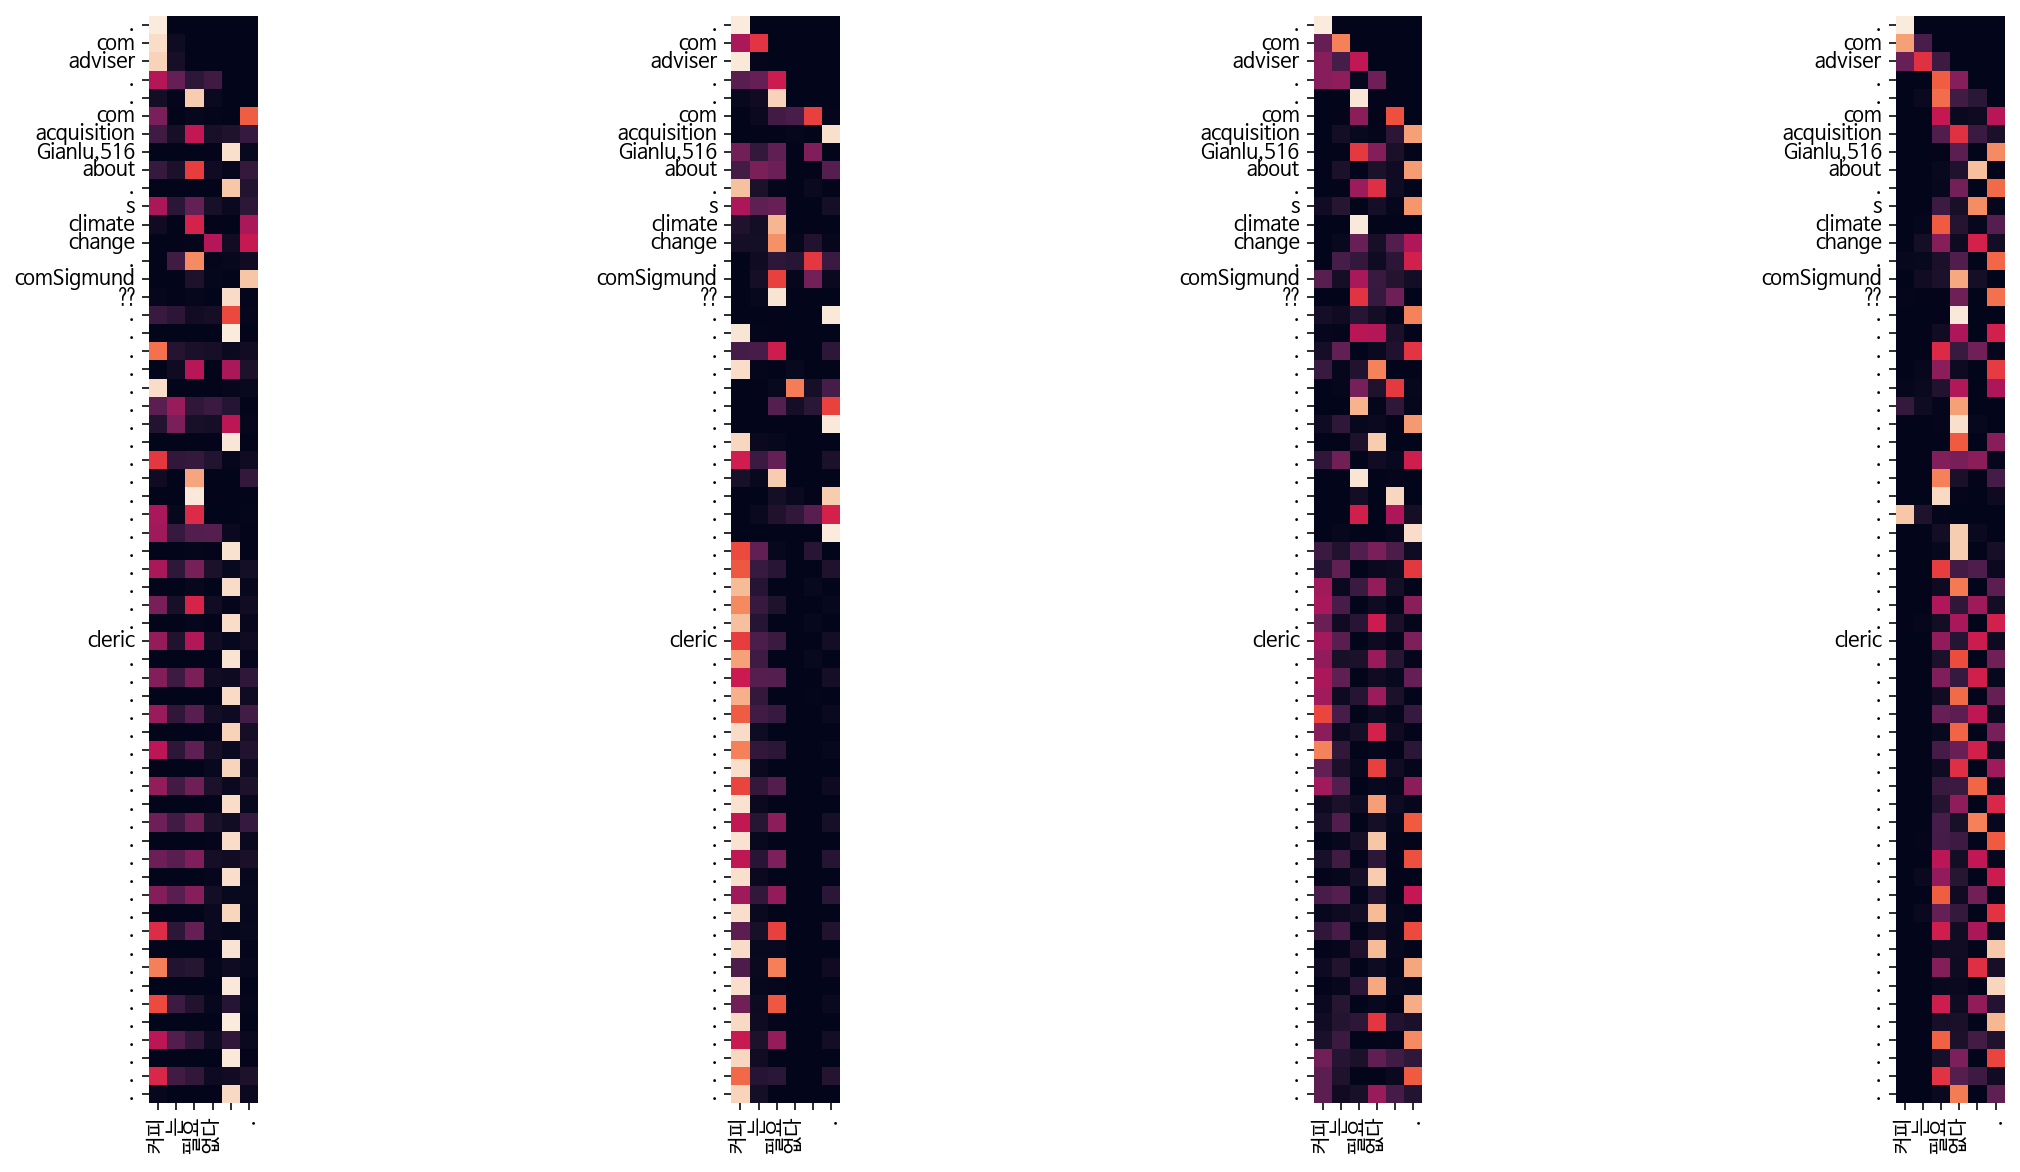

Decoder Self Layer 2


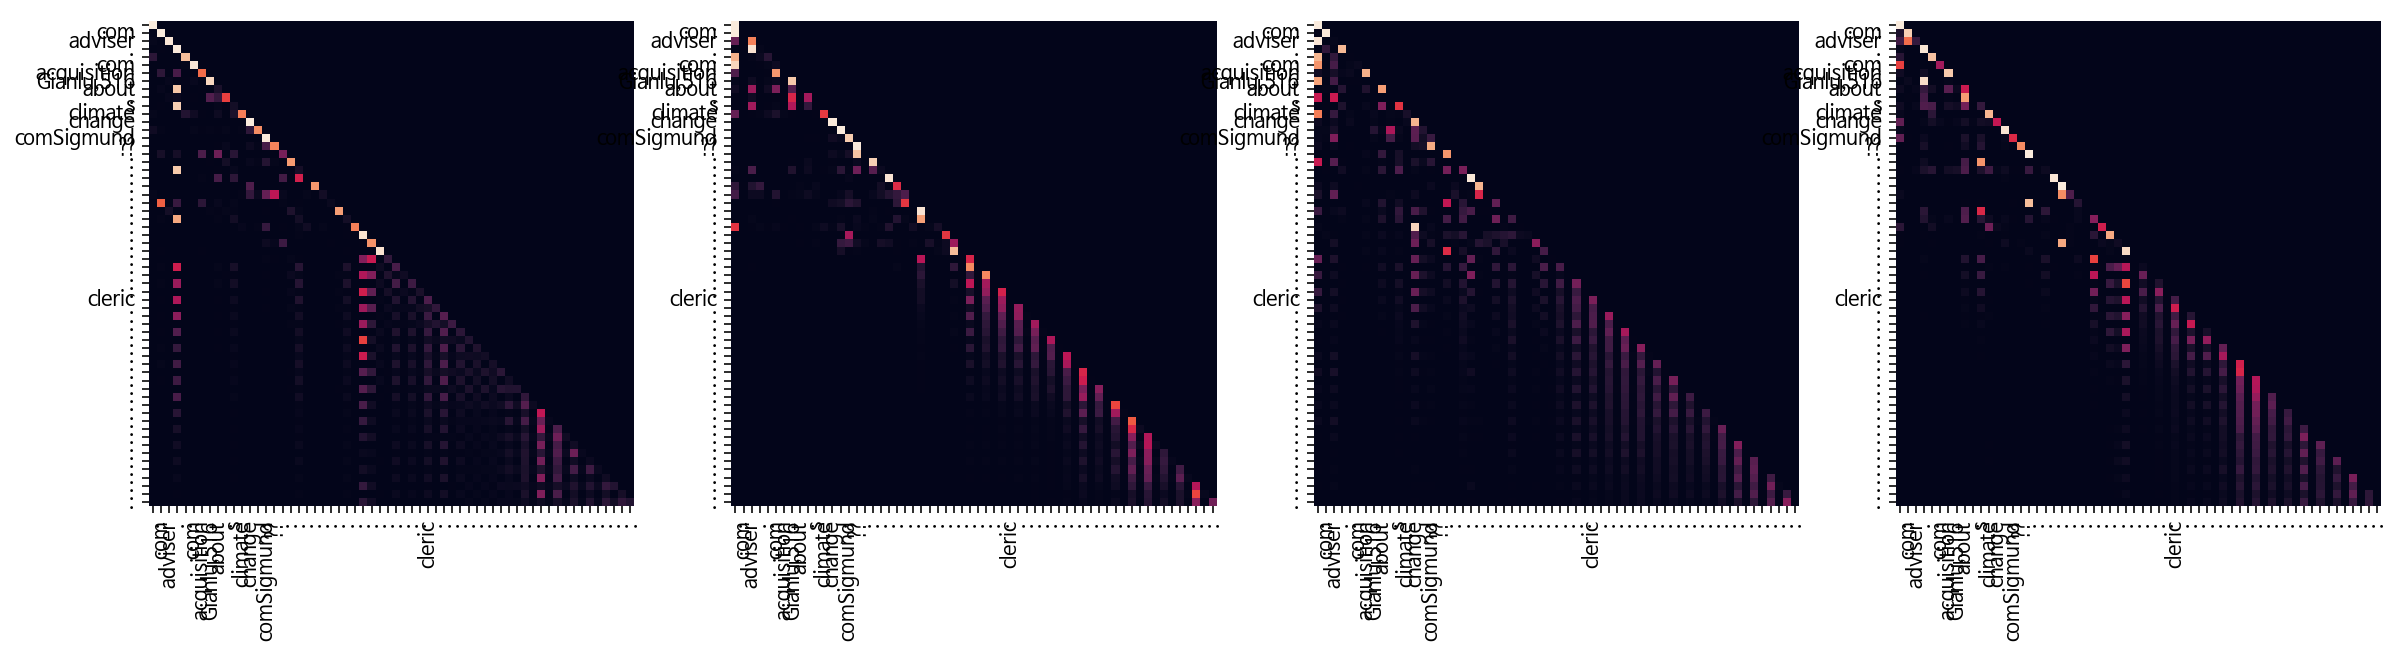

Decoder Src Layer 2


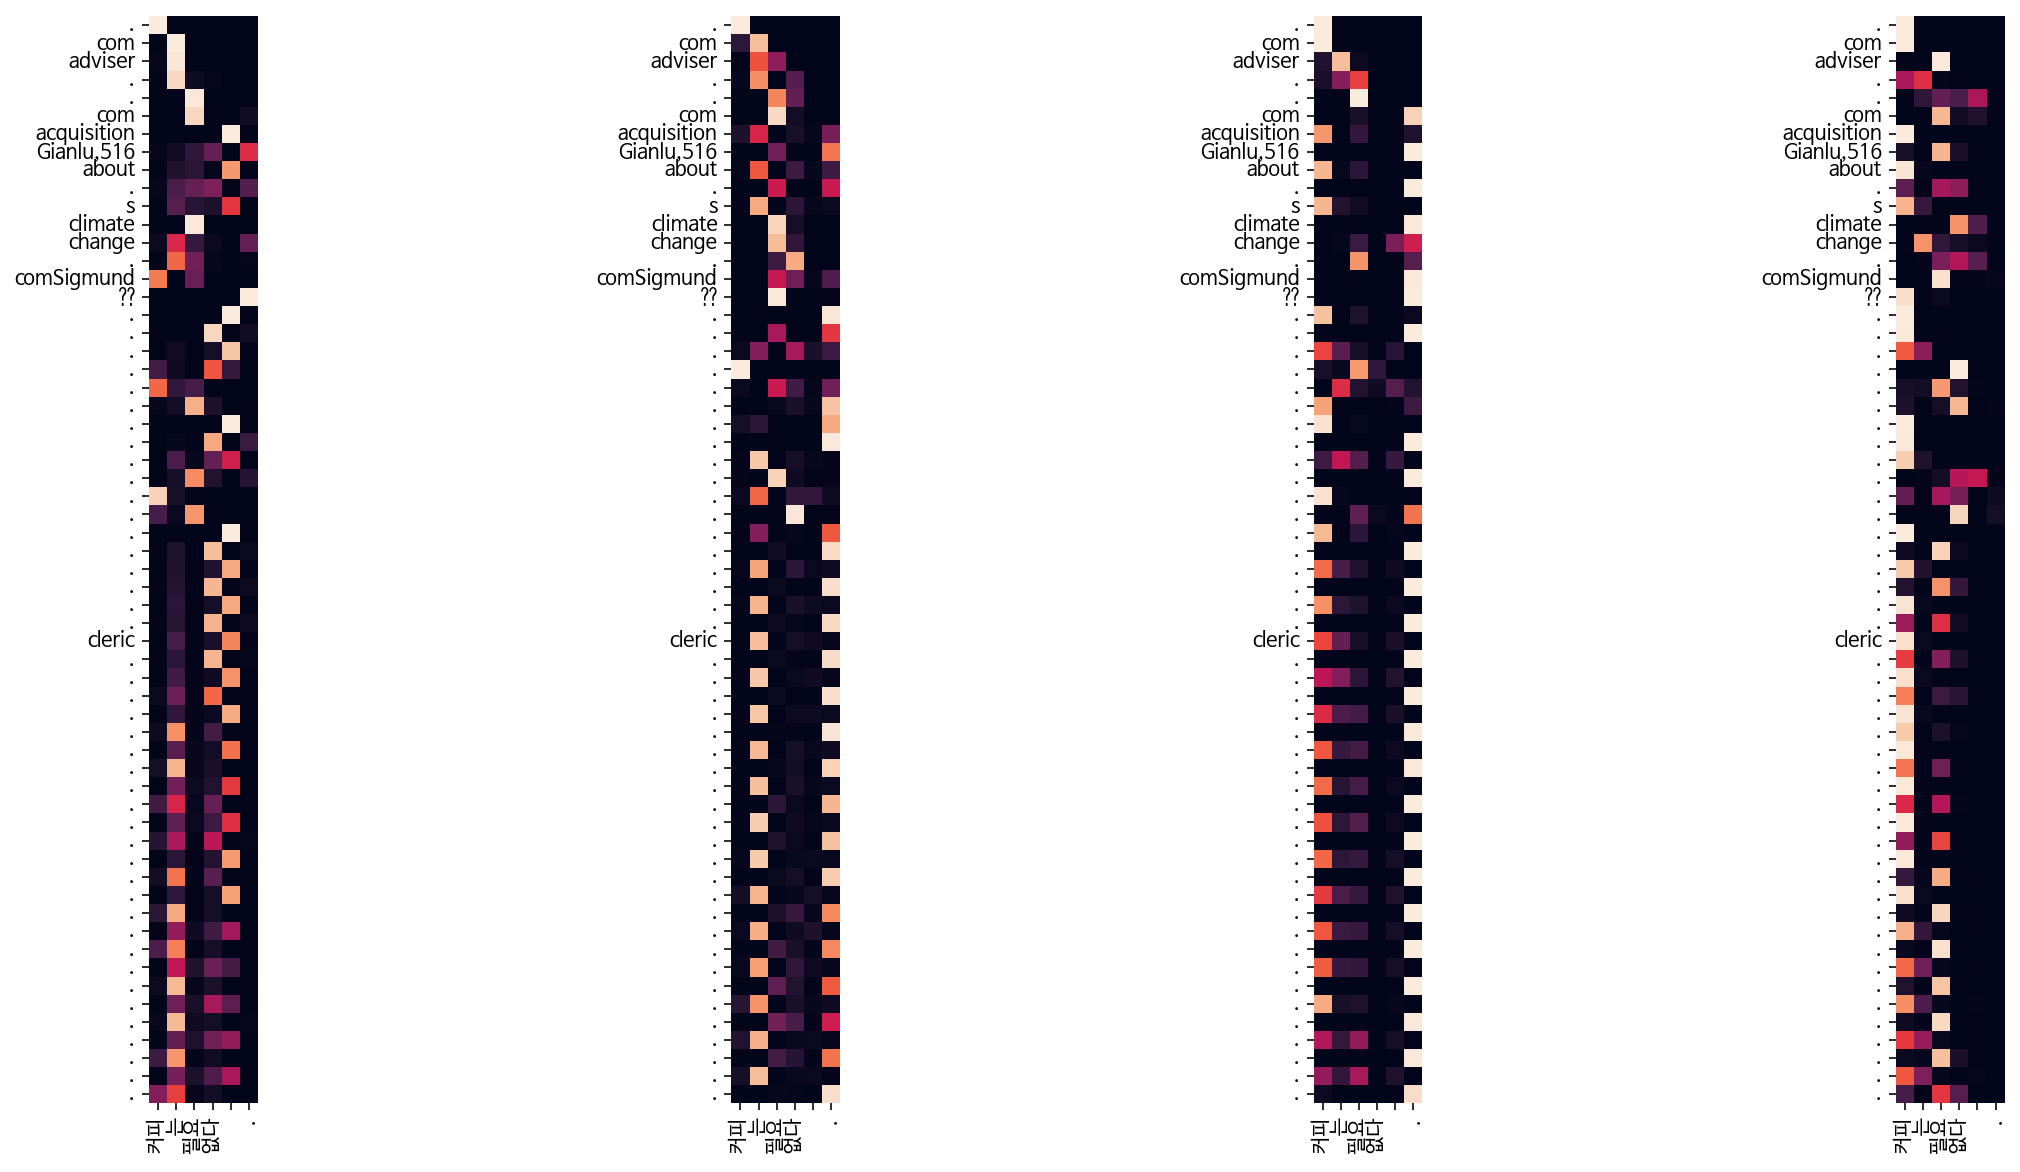

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: EC samadianal were in connection with four people dead . com . . . . . . . . com sunday . com sovereignsha need . . com . . . . . . . . . . . . . . . . . . . . . . . . embryosteve . to do . Osa . . 
Encoder Layer 1


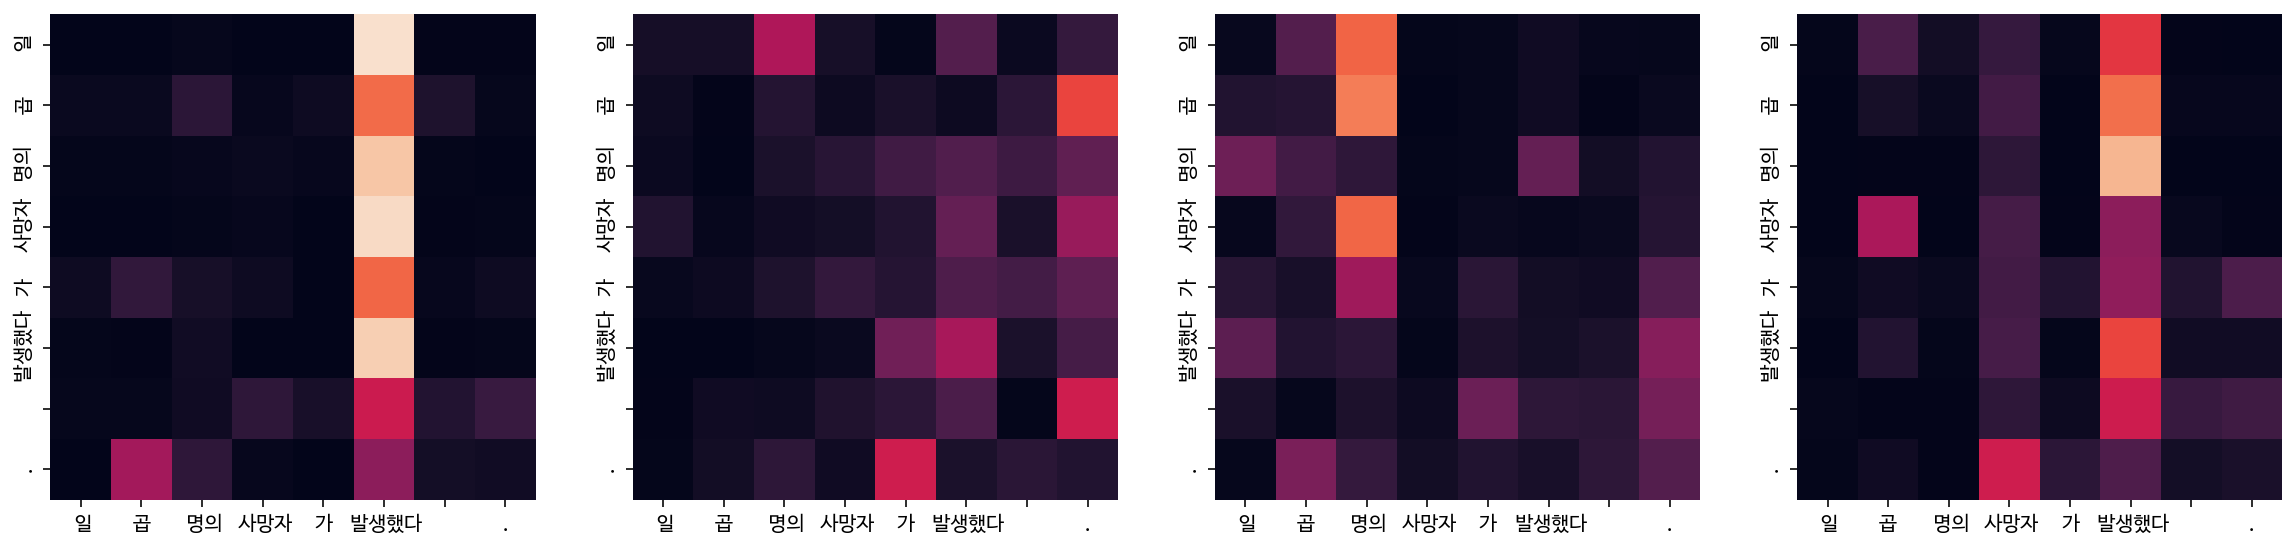

Encoder Layer 2


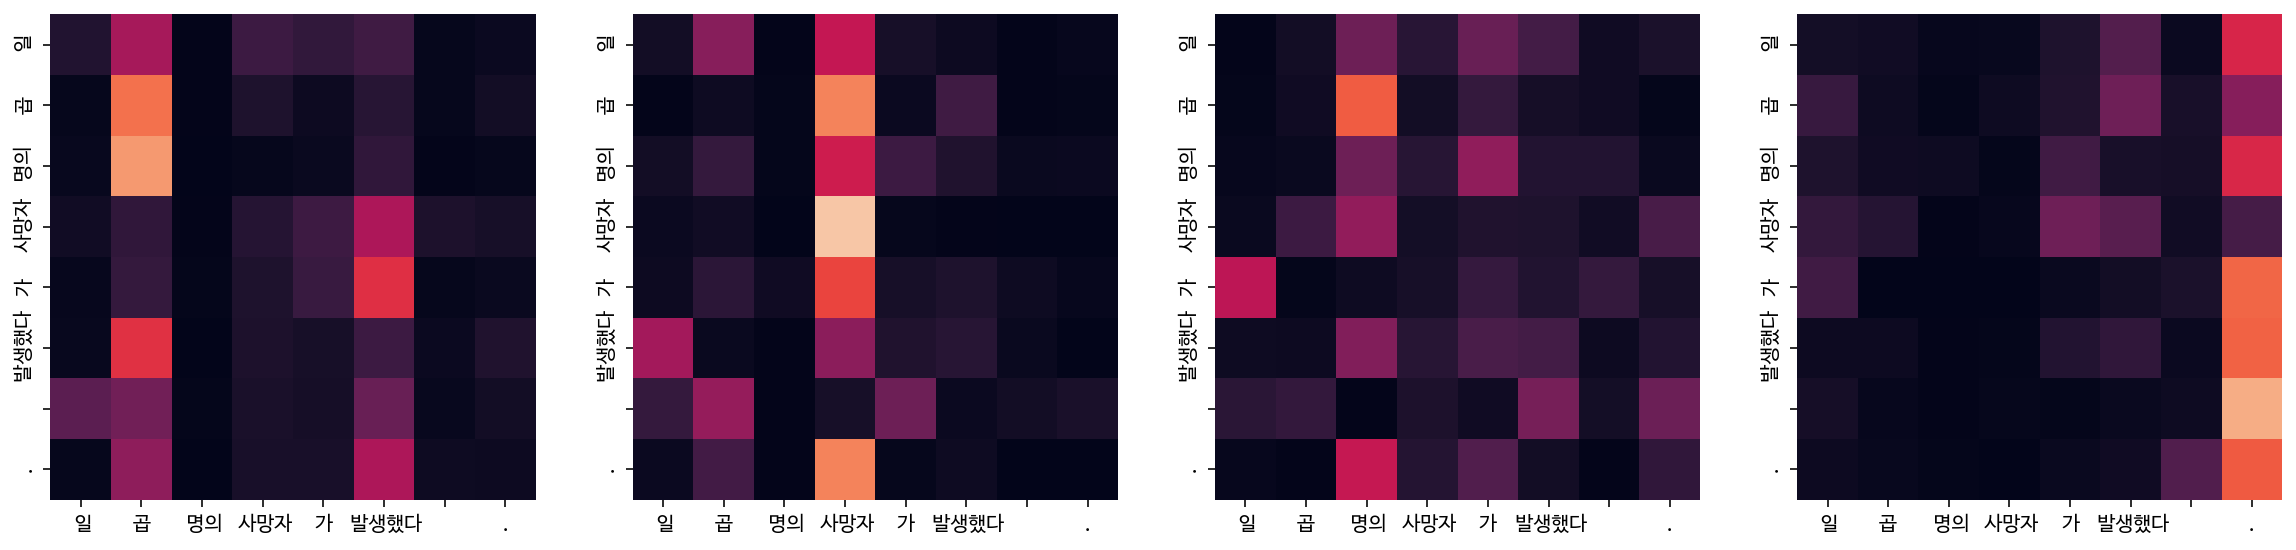

Decoder Self Layer 1


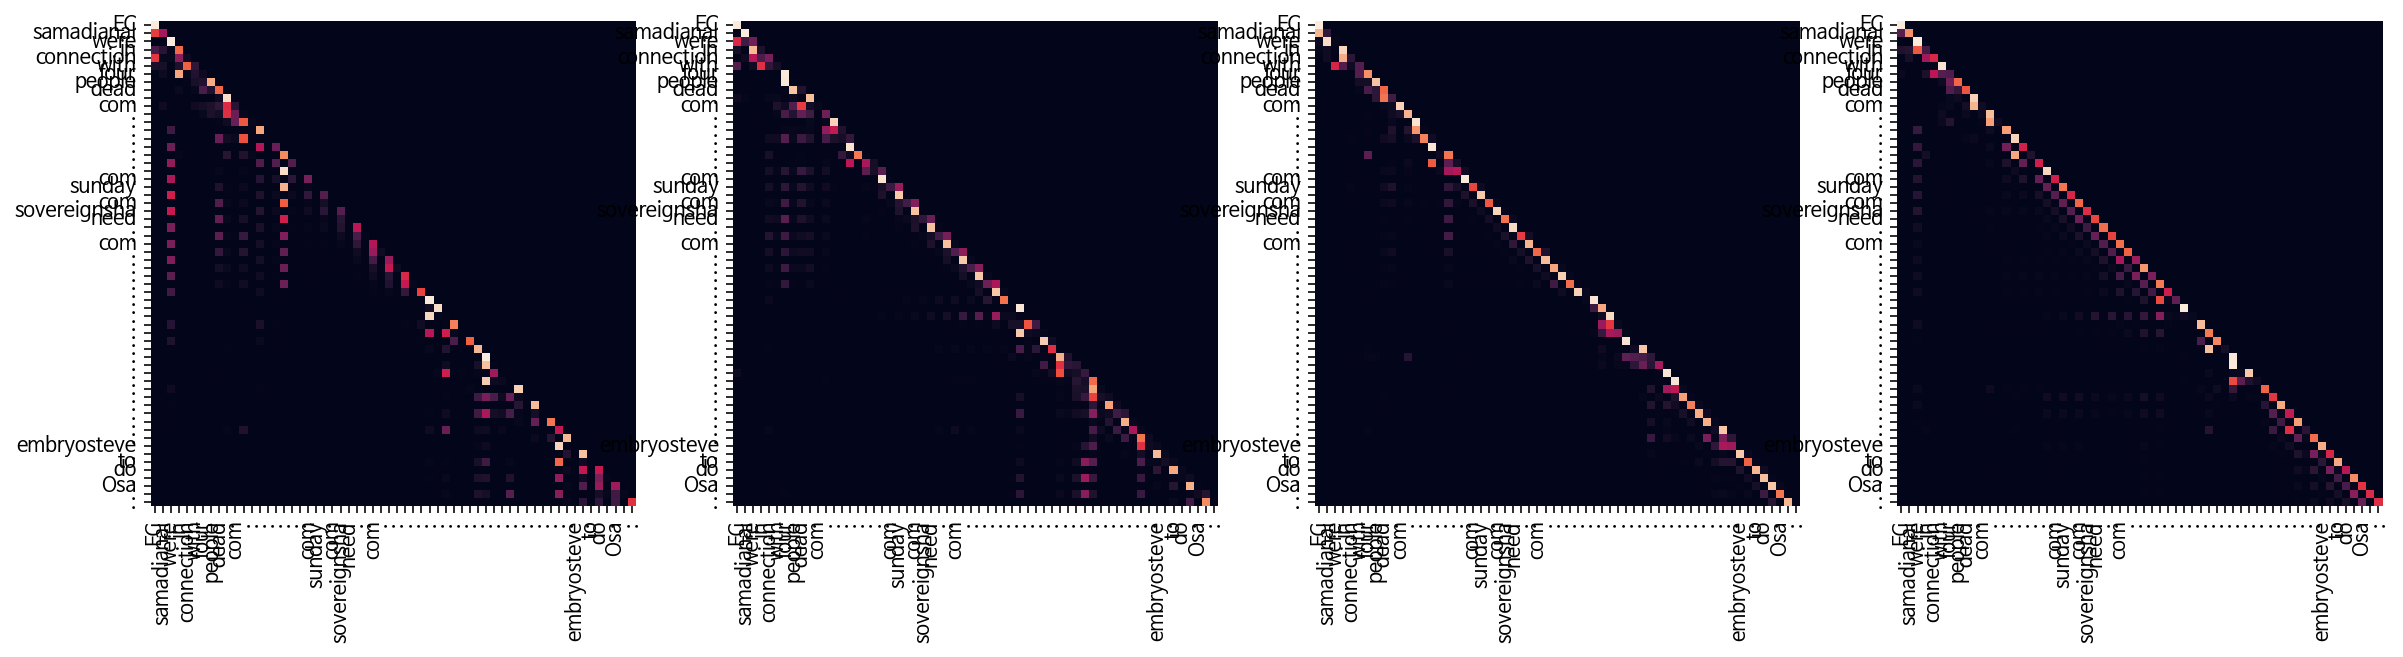

Decoder Src Layer 1


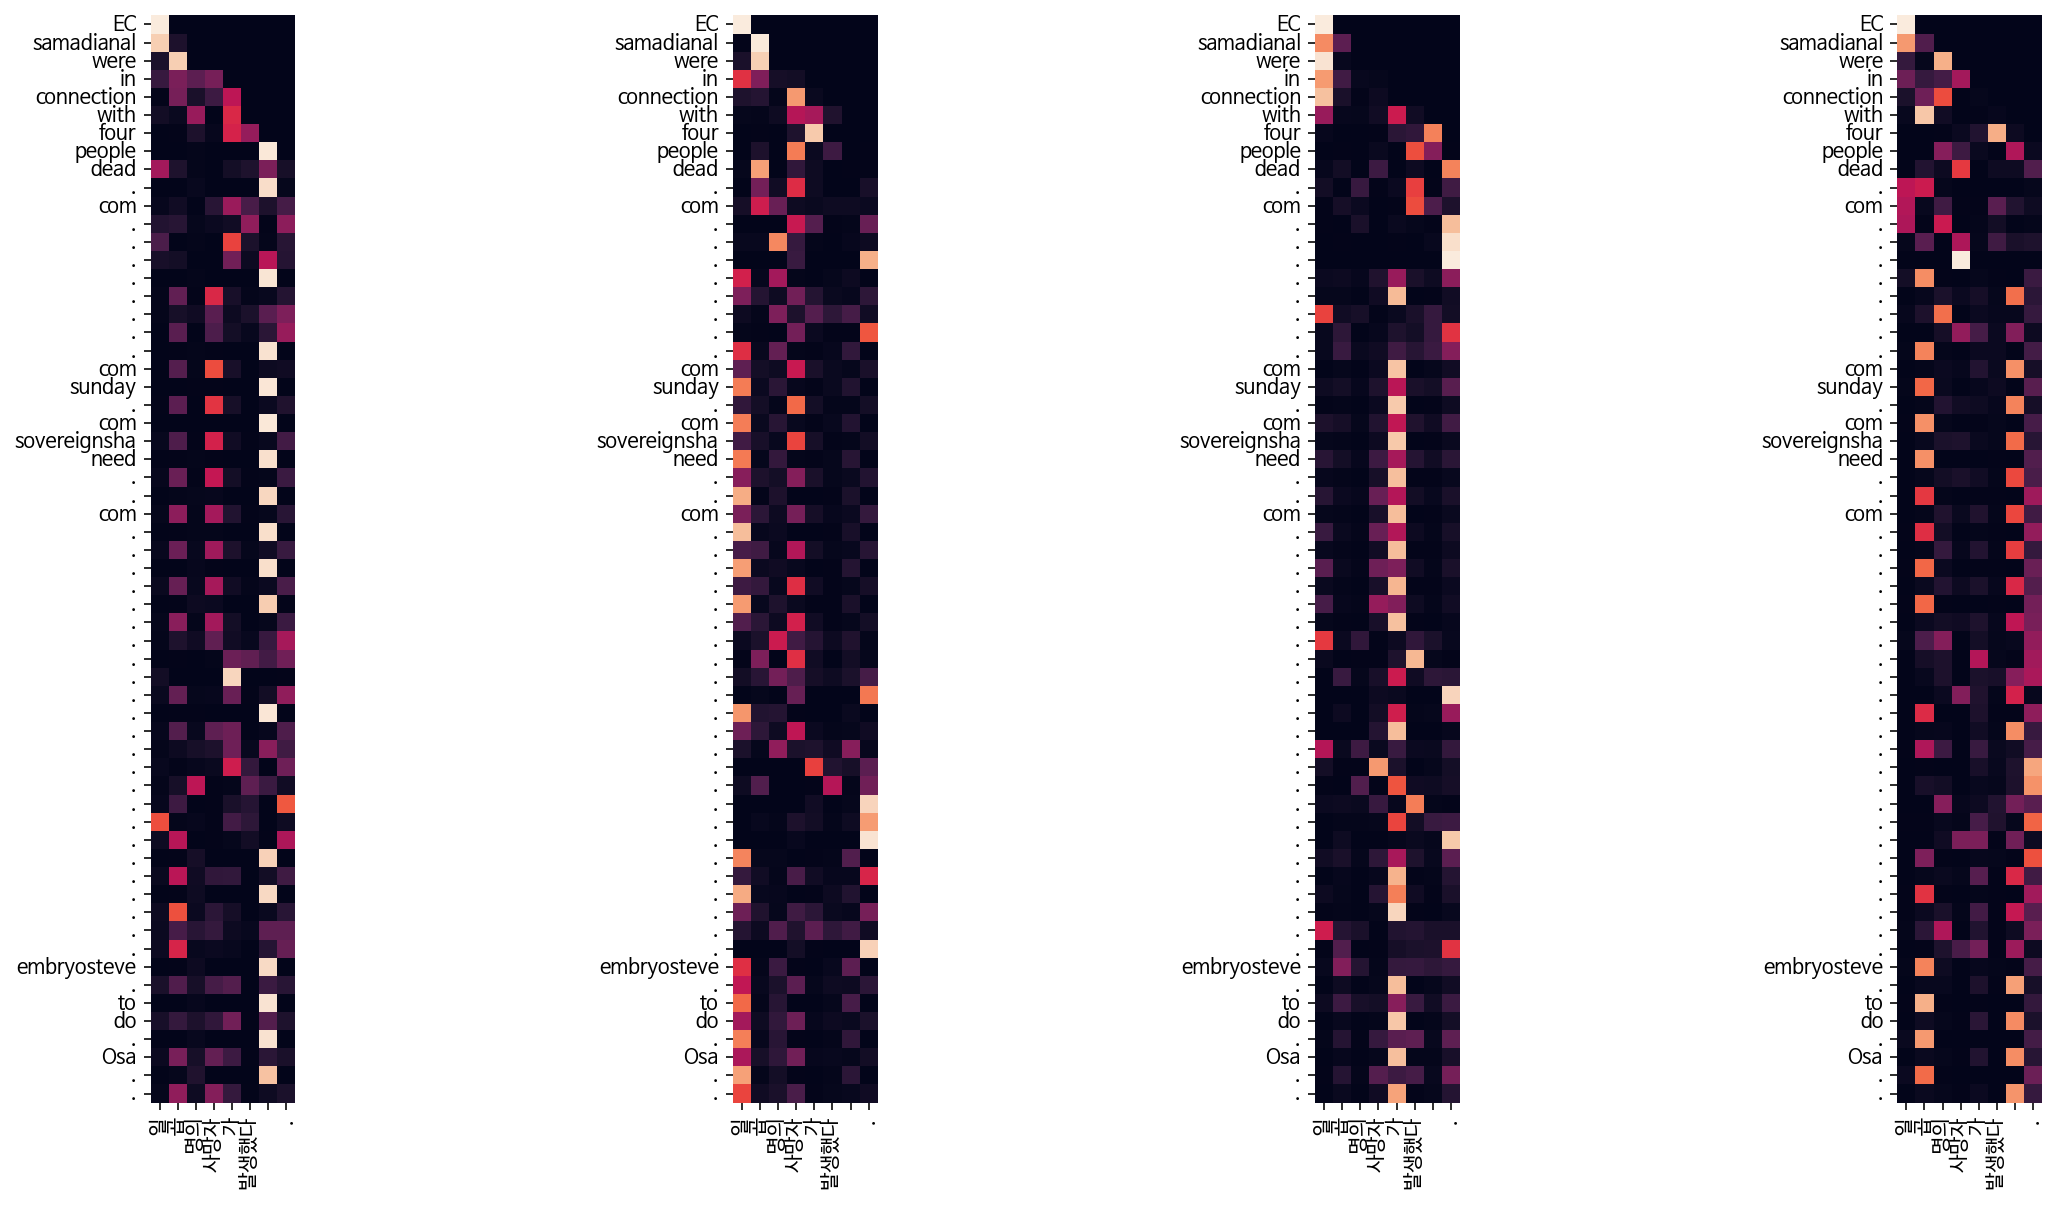

Decoder Self Layer 2


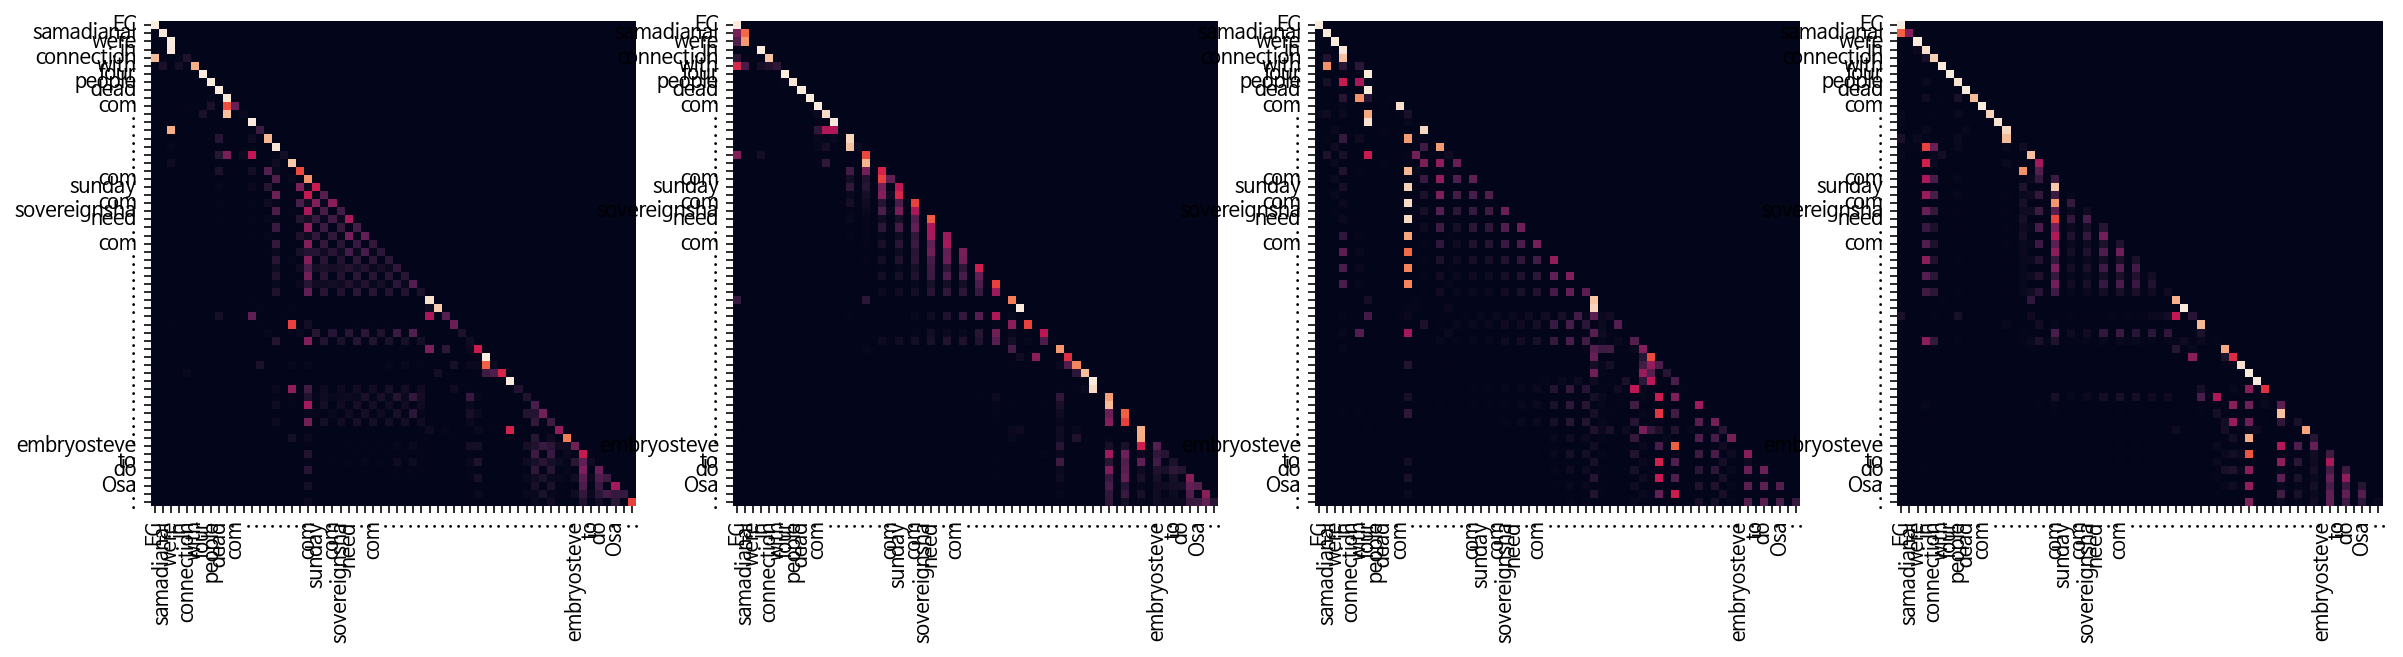

Decoder Src Layer 2


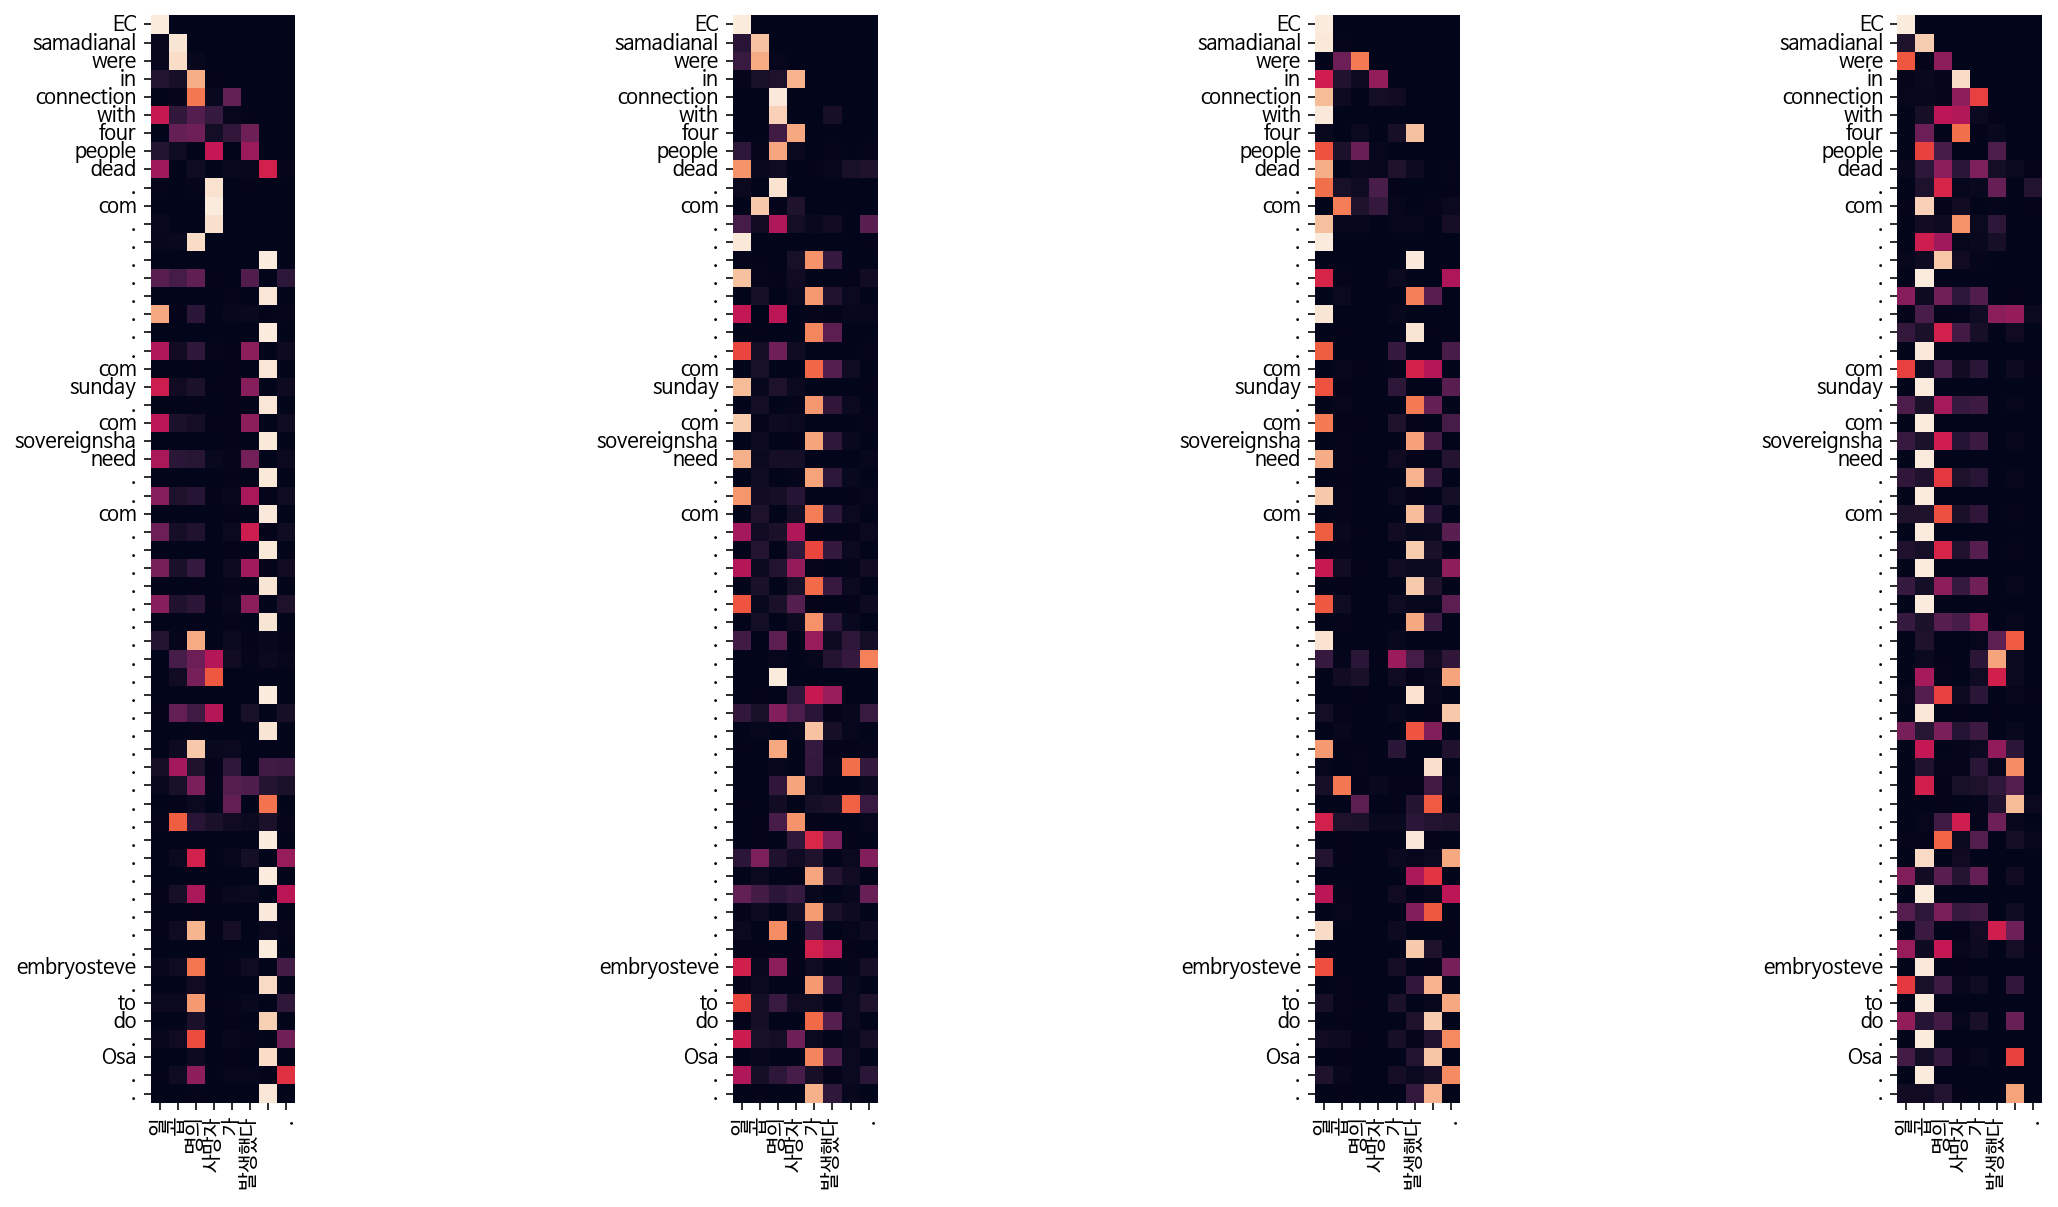

In [27]:
from tqdm import tqdm

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    Tran,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

for example in examples:
    translate(example, Tran, sp_k, sp_e, True)

<회고>
* 예문에 대한 결과 : 대체로 4가지 예문에 대한 결과는 한글 입력문의 단어 단위에 해당되는 영단어가   
  나오기는 했습니다. 그러나 멋진 번역까지는 도달하지 못한 것 같아 아쉽네요. 그러나 엔코더나 디코더 그리고 어텐션  
  시각화를 보면 가로축에 나오는 입력 단어에 대해, 문장에서 다음에 나오는 입력 단어가 세로축에 위치하여 입력  
  단어와 만나는 확률의 정도가 의외로 큼을 알 수 있었습니다.  
  
* 이 결과에 쓰인 상수들은 이렇습니다.    
  
  d_model = 512; n_layers = 2; n_heads = 8; d_ff = 2048  
  dropout = 0.1; pos_len = 512  
  seq_len = 50; src_vocab_size = SRC_VOCAB_SIZE = 30000  
  tgt_vocab_size = TGT_VOCAB_SIZE = 30000  
  
  Tran = Transformer(n_layers, d_model, n_heads, d_ff, src_vocab_size, tgt_vocab_size, pos_len, dropout=0.2, shared=True)  
  learning_rate = LearningRateScheduler(512)  
  optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)  
  
  warmup_steps = 4000  
  BATCH_SIZE = 64  
  EPOCHS = 20  
      
  
* 이번 과제는 사실 복잡해 보이지만 몇가지 규칙성이 있었습니다.  
  첫째로 여러 함수나 클래스를 정의할 때 후에 정의되는 함수 구현 안에 전에 정의된 함수가 이미 구현되어 있는 경우가  
  많다는 점입니다. 따라서 마지막 조립단계인 트랜스포머 객체를 만들어주면 이전의 다른 클래스는 자동으로 구현되는  
  느낌을 받았습니다. 두번째로는 함수의 출력 결과로 마스크나 어텐션이 나오는 경우가 있는데 그 출력이 다시 어떤  
  함수의 입력으로 가는지 알면 전체 구조를 이해하는데 도움이 될 것 같습니다.    
  예를 들어 가끔은 출력으로 나온 마스크가 다른 마스크 제작 함수의 입력으로 들어가기도 하고   
  어텐션 출력은 다른 클래스의 구현에서 다시 등장하는 경우도 있었습니다.   
  (ex.엔코더 레이어 디코더 레이어 등에서 멀티헤드어텐션 형태의 함수로 어텐션을 넘겨받음)     